# Stimulated emission protocol with SNAP pulses followed by repeated π (n+1 and n+1) , Chi2 correction

In [1]:
from pylab import*
import matplotlib.pyplot as plt
import seaborn as sns
from h5py import File
import pandas as pd
from slab.dsfit import*
import json
import numpy as np
from datetime import datetime
import scipy as sc
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
# from qutip import *
from h5py import File
import os
from slab.dataanalysis import get_next_filename
from slab.datamanagement import SlabFile

C:\ProgramData\Miniconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Fit functions

In [2]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def storage_t1(t, a, k):
    alpha = alpha_awg_cal(cav_amp=cav_amp, cav_len=cav_len)
    return a*np.exp(-alpha**2*np.exp(-k*t))

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y

def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/10.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, N))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0], np.sqrt(pcov[0][0])

def expfunc2(x, p):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*np.exp**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, a, b, c):
    return b*np.exp(-(x-a)/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def decaysin_ramsey(x, a, b, c, d, e, f):
    """p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-p[5])/p[3])+p[4]"""
    return a*np.sin(2.*np.pi*b*x+c*np.pi/180.)*np.exp(-1.*(x-f)/d)+e

def gauss(x, mu, sigma, a):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def bimodal(x, mu1, sigma1, a1, mu2, sigma2, a2):
    return gauss(x, mu1, sigma1, a1) + gauss(x, mu2, sigma2, a2)

def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
    ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        popt, pcov = curve_fit(bimodal, xdata=binsg[:-1], ydata=ng, p0=None)
        mu_g = popt[0]
        axs[2].plot(binsg, bimodal(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        popt, pcov = curve_fit(bimodal, xdata=binse[:-1], ydata=ne, p0=None)
        mu_e = popt[3]
        axs[2].plot(binse, bimodal(binse, *popt), 'k--', linewidth=2 )
#         axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)
        axs[2].set_xlabel('I(a.u.)')        
        axs[2].set_title('F = %.3f'%fid)
        fig.show()
        
    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)

def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

# HMM Model

In [6]:
class hmm_analysis_stimem():

    def __init__(self, qubit_params = None, cavity_params = None, readout_params = None):
        
        self.qubit_params = qubit_params
        self.cavity_params = cavity_params
        self.readout_params = readout_params

        """All the timescales are in μs"""
        self.qubit_t1 = self.qubit_params['t1']
        self.qubit_t2 = self.qubit_params['t2']
        self.qubit_nth = self.qubit_params['nth']
        
        self.cavity_t1 = self.cavity_params['t1']
        self.cavity_nth = self.cavity_params['nth']
        
        self.readout_len = self.readout_params['length']        
        self.trigger_period = self.readout_params['trigger']
        self.pi_length = self.readout_params['pi_pulse']
        self.g_inf = self.readout_params['g_inf']        
        self.e_inf = self.readout_params['e_inf']      
        
    ##----------------------------------------------------------------##
    def forward(self, meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

    def backward(self, meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta

    def likelihood(self, meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  self.forward(meas_seq, T, E)[-1].sum()

    def gamma(self, meas_seq, T, E):
        alpha = self.forward(meas_seq, T, E)
        beta  = self.backward(meas_seq, T, E)
        obs_prob = self.likelihood(meas_seq, T, E)
        return (multiply(alpha, beta.T) / obs_prob)

    def viterbi(self, meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    ##----------------------------------------------------------------##
    def alpha_awg_cal(self, cav_amp=0.4, cav_len=250):
        # takes input array of amps and length and converts them to output array of alphas,
        # using a calibration h5 file defined in the experiment config
        # pull calibration data from file, handling properly in case of multimode cavity
        cal_path = 'C:\_Lib\python\slab\experiments\qm_opx_mm\drive_calibration'

        fn_file = cal_path + '\\00000_2021_12_16_cavity_square_mode_2.h5'

        with File(fn_file, 'r') as f:
            omegas = np.array(f['omegas'])
            amps = np.array(f['amps'])

        # assume zero frequency at zero amplitude, used for interpolation function
        omegas = np.append(omegas, 0.0)
        amps = np.append(amps, 0.0)

        o_s = omegas
        a_s = amps

        # interpolate data, transfer_fn is a function that for each amp returns the corresponding omega
        transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

        omega_desired = transfer_fn(cav_amp)
        alpha = omega_desired * cav_len

        """Returns alpha in the cavity"""
        return alpha
        
    ##----------------------------------------------------------------##
    def openfile(self, filename):
        
        return File(filename,'r')

    def stateprep(self, data_filename=None, at_end=True, t2_err=0.0, fstate_in=0, hist_file=None, inc_pi_pulse=None):
        
        """Readout fidelities from an independent measurement"""
        g_infidelity, e_infidelity = self.g_inf, self.e_inf
        
        self.a = self.openfile(data_filename)

        I = pd.DataFrame(self.a['I'])[:]
        Q = pd.DataFrame(self.a['bit'])[:]
        
        cav_amp = np.array(self.a['amp']) 
        cav_len = np.array(self.a['time']) 
        
        npi_m = int(np.array(self.a['pi_m']))
        npi_n = int(np.array(self.a['pi_n']))
        alpha = np.array(self.a['alpha'])

        self.a.close()
        
        print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
        print('Coherent drive: amp = {}, length = {} ns'.format(cav_amp, cav_len))

        p_m_counts = []
        p_n_counts = []
        
        """T and E matrices for the state prep part, π pulses at m (~n)"""
        if fstate_in ==0:
            cavity_t1 = self.cavity_t1/(fstate_in+1)
            #W is the m_bar state (undesired)
            Pmw = self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1)) #Only spontaneous excitation
            Pwm = (1-np.exp(-self.trigger_period/cavity_t1)) #Exponential decay

        else:
            cavity_t1 = self.cavity_t1/(fstate_in)
            Pmw = (1-np.exp(-self.trigger_period/cavity_t1)) +\
                        self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1)) + \
                        self.cavity_nth * (1-np.exp(-self.trigger_period/(self.cavity_t1/(fstate_in+1))))
            
            Pwm = self.cavity_nth * (1-np.exp(-self.trigger_period/(self.cavity_t1/(fstate_in))))
        
        Pmm = 1-Pmw
        Pww = 1-Pwm    
        """First term corresponds to to a spontaneous heating to the higher state (n+1) and
            the second terms corresponds to decay to a lower Fock state (n-1). 
            However, it is very unlikely that the cavity will start in (n+1) state
        """
        Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                                    (1-np.exp(-self.pi_length/self.qubit_t2))
        Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                        (1-np.exp(-self.pi_length/self.qubit_t2))
        Pgg = 1 - Pge
        Pee = 1- Peg
        """There is a sublte difference in the transition matrix for the first part as 
        compared to the photon counting matrix. Here the qubit should flip if it was prepared
        in the correct Fock state (m or !n). 
        """

        T_m = asarray([[Pww*(Pgg), Pww*Pge, Pwm*Pge, Pwm*(Pgg)],
             [Pww*Peg, Pww*(Pee), Pwm*(Pee), Pwm*Peg],
             [Pmw*(Pgg), Pmw*Pge, Pmm*Pge, Pmm*(Pgg)],
             [Pmw*Peg, Pmw*(Pee), Pmm*(Pee), Pmm*Peg]])

        E_m = 0.5*asarray([[1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity],
            [1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity]])     

        """T and E matrices for the second half of the experiment"""
        cavity_t1 = self.cavity_t1/(fstate_in + 1)
        
        Pmw = (1-np.exp(-self.trigger_period/cavity_t1)) + \
                                    self.cavity_nth *(1-np.exp(-self.trigger_period/(self.cavity_t1/(fstate_in + 2))))
        #assuming that the population at (n+1) is negligible and (n-1) we will estimate
        Pwm = self.cavity_nth *(1-np.exp(-self.trigger_period/(self.cavity_t1/(fstate_in+1))))

        Pmm = 1-Pmw
        Pww = 1-Pwm    

        Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                                    (1-np.exp(-self.pi_length/self.qubit_t2))
        Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
                        (1-np.exp(-self.pi_length/self.qubit_t2))
        Pgg = 1 - Pge
        Pee = 1- Peg

        T_n = asarray([[Pww*(Pgg), Pww*Pge, Pwm*Pge, Pwm*(Pgg)],
             [Pww*Peg, Pww*(Pee), Pwm*(Pee), Pwm*Peg],
             [Pmw*(Pgg), Pmw*Pge, Pmm*Pge, Pmm*(Pgg)],
             [Pmw*Peg, Pmw*(Pee), Pmm*(Pee), Pmm*Peg]])

        E_n = 0.5*asarray([[1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity],
            [1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity]])
        
        if inc_pi_pulse is None:
            inc_pi_pulse = npi_m
            
        for jj in range(len(Q)):
            """State preparation probabilities at the end or at the beginning of m π pulses"""
            meas_seq = np.array(Q.iloc[jj][:inc_pi_pulse])
            gamma_matrix = self.gamma(meas_seq, T_m, E_m)
            if at_end==True: #Probablitity of state surviving till the end
                Pw_last = gamma_matrix[-1,0] + gamma_matrix[-1,1]
                Pm_last = gamma_matrix[-1,2] + gamma_matrix[-1,3]
            else:#Probability at the beginnning
                Pw_last = gamma_matrix[0,0] + gamma_matrix[0,1]
                Pm_last = gamma_matrix[0,2] + gamma_matrix[0,3]
            pm_temp=(Pm_last/Pw_last)         

            """After the coherent drive, probabilities at the begining of n π pulses"""    
            meas_seq = np.array(Q.iloc[jj][npi_m-1:])
            gamma_matrix = self.gamma(meas_seq, T_n, E_n)
            Pw_first = gamma_matrix[0,0] + gamma_matrix[0,1]
            Pm_first = gamma_matrix[0,2] + gamma_matrix[0,3]   
            pn_temp=(Pm_first/Pw_first)

            p_m_counts.append(pm_temp)
            p_n_counts.append(pn_temp)

        return alpha, cav_amp, p_m_counts, p_n_counts

# Debugging

## Expected Poisson distribution

1.0 72


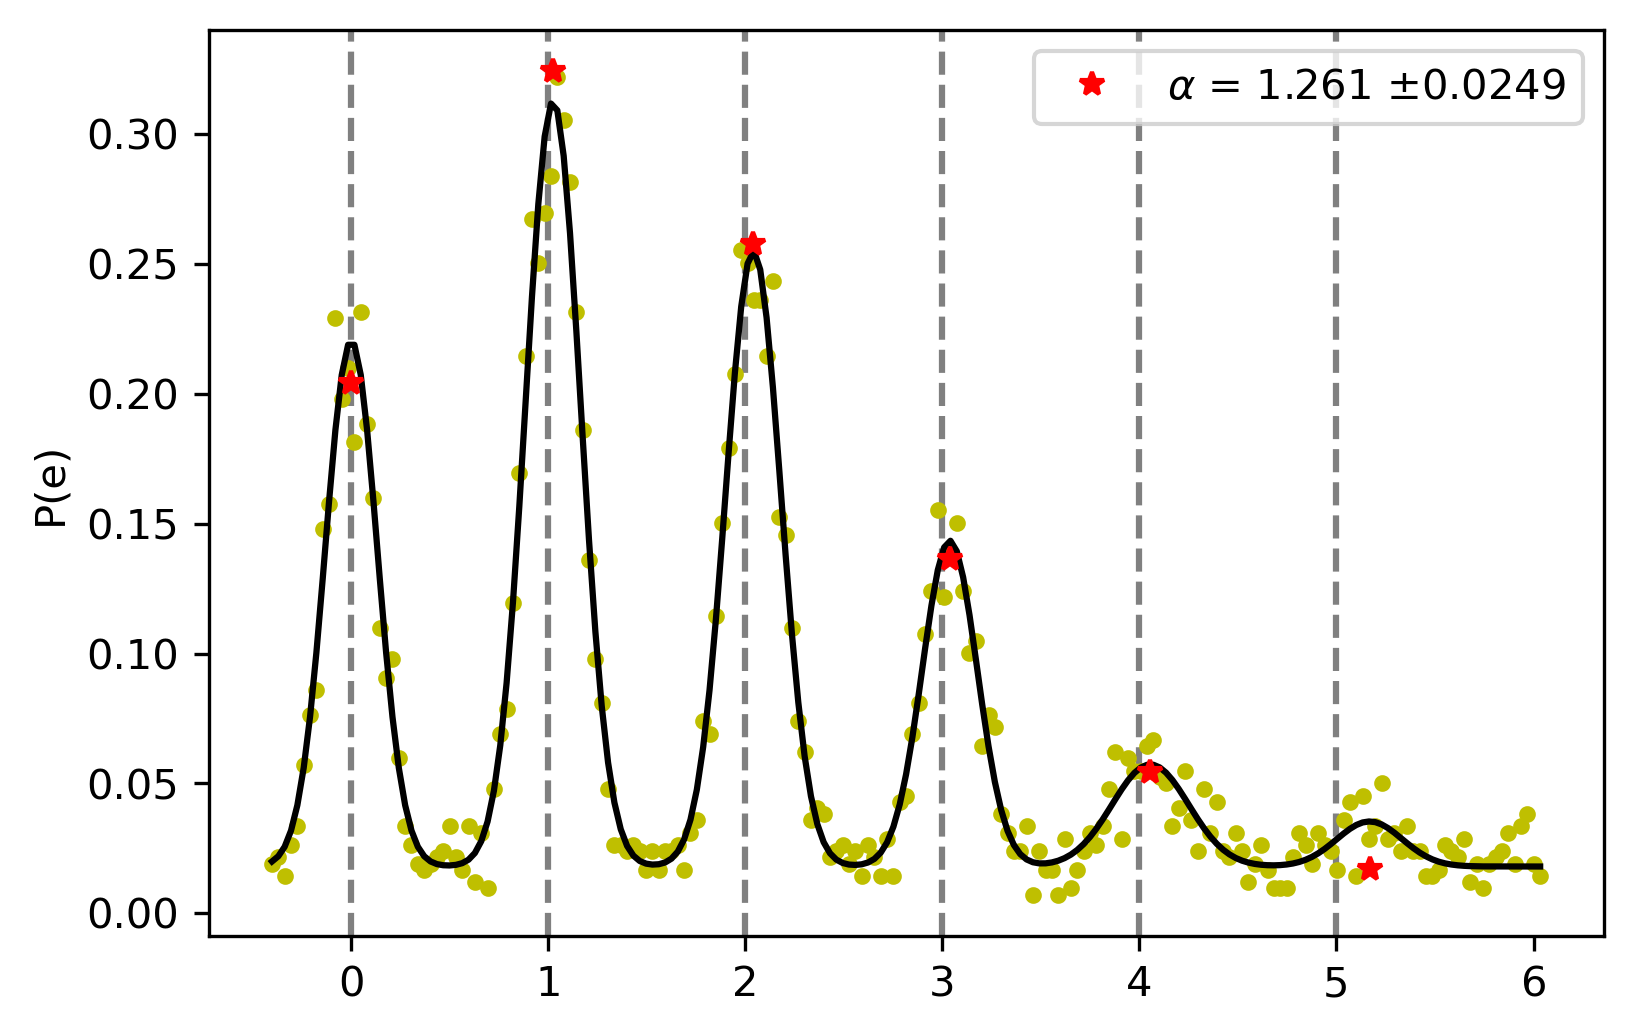

In [3]:
expt_name = 'number_splitting'
filelist = [0]

qubit_freq = 4.746910599438208
N = 6

two_chi_meas = []

for ii, i in enumerate(filelist):
    filename = str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as f:

        I = np.array(f['I'])[:]
        Q = np.array(f['Q'])[:]
        cav_amp = np.array(f['amp'])
        cav_len = np.array(f['time'])
        two_chi = np.array(f['two_chi'])
        freqs = (np.array(f['freq']))/(two_chi)
        f.close()
        print(cav_amp, cav_len)
        x = freqs
        """Scaling the probability values with g and e"""
        y = Q 
        
        plt.figure(dpi=300)

        for j in range(N):
            plt.axvline(x=j, linestyle='--', color='grey')
        plt.plot(x, y, '.', color='y') 
        
        fitparams = np.zeros(3*N+1)
        fitparams[0] = 0

        for kk in range(N):
            fitparams[3*kk+1] = max(y)
            fitparams[3*kk+2] = kk
            fitparams[3*kk+3] = 0.32

        p1, p2 = fitgausssum_with_baseline(x, y, fitparams=fitparams)
        
        plt.plot(x, gaussfuncsum_with_baseline(x, *p1), 'k')                   

        peak_val, freq_val = fitamp(p1)
        
        two_chi_meas.append(abs(two_chi)*(p1[5]-p1[2])/1e6)
        
        a, a_err = fitcoherentstate(peak_val)
        plt.plot(freq_val, coherent_state(np.arange(len(peak_val)), a), 'r*', label=r'$\alpha$ = {} $\pm {}$'.format(np.round(a, 3), np.round(a_err, 4)))
        
        plt.ylabel('P(e)')
        plt.legend(loc='best')
        plt.show()

In [4]:
alpha_exp = 1.261
n = np.arange(4)
exp_pop = coherent_state(n, alpha_exp)
print(exp_pop)

[0.20390094 0.32422716 0.25778021 0.13663391]


## Probability at the end

In [7]:
import json
filename = '00000_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

p_m_counts = []
p_n_counts = []
camp = 0.0

for fock_state in range(4):
    
    data_path = 'n' + str(fock_state)+'//'
    inj_path = 'n' + str(fock_state)+'//injected_photon//'

    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)

    filename = data_path+filelist[0]
    obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
    p_m_counts.append(p_m)
    p_n_counts.append(p_n)
    
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m)
        f.create_dataset("p_n_counts", data=p_n)
        f.create_dataset("alpha", data = alpha)
        f.close()


['00000_stim_em_n0_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns


KeyboardInterrupt: 

## Probability at the beginning

In [8]:
import json
filename = '00000_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

p_m_counts = []
p_n_counts = []
camp = 0.0

for fock_state in range(4):
    
    data_path = 'n' + str(fock_state)+'//'
    inj_path = 'n' + str(fock_state)+'//injected_photon//'

    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)

    filename = data_path+filelist[0]
    obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=False, hist_file=None, fstate_in=fock_state)
    p_m_counts.append(p_m)
    p_n_counts.append(p_n)
    
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+"_begin.h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m)
        f.create_dataset("p_n_counts", data=p_n)
        f.create_dataset("alpha", data = alpha)
        f.close()


['00000_stim_em_n0_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
n0//injected_photon//n0_camp_0.0_begin.h5
['00000_stim_em_n1_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
n1//injected_photon//n1_camp_0.0_begin.h5
['00000_stim_em_n2_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
n2//injected_photon//n2_camp_0.0_begin.h5
['00000_stim_em_n3_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
n3//injected_photon//n3_camp_0.0_begin.h5


n0//injected_photon//n0_camp_0.0.h5
n1//injected_photon//n1_camp_0.0.h5
n2//injected_photon//n2_camp_0.0.h5
n3//injected_photon//n3_camp_0.0.h5


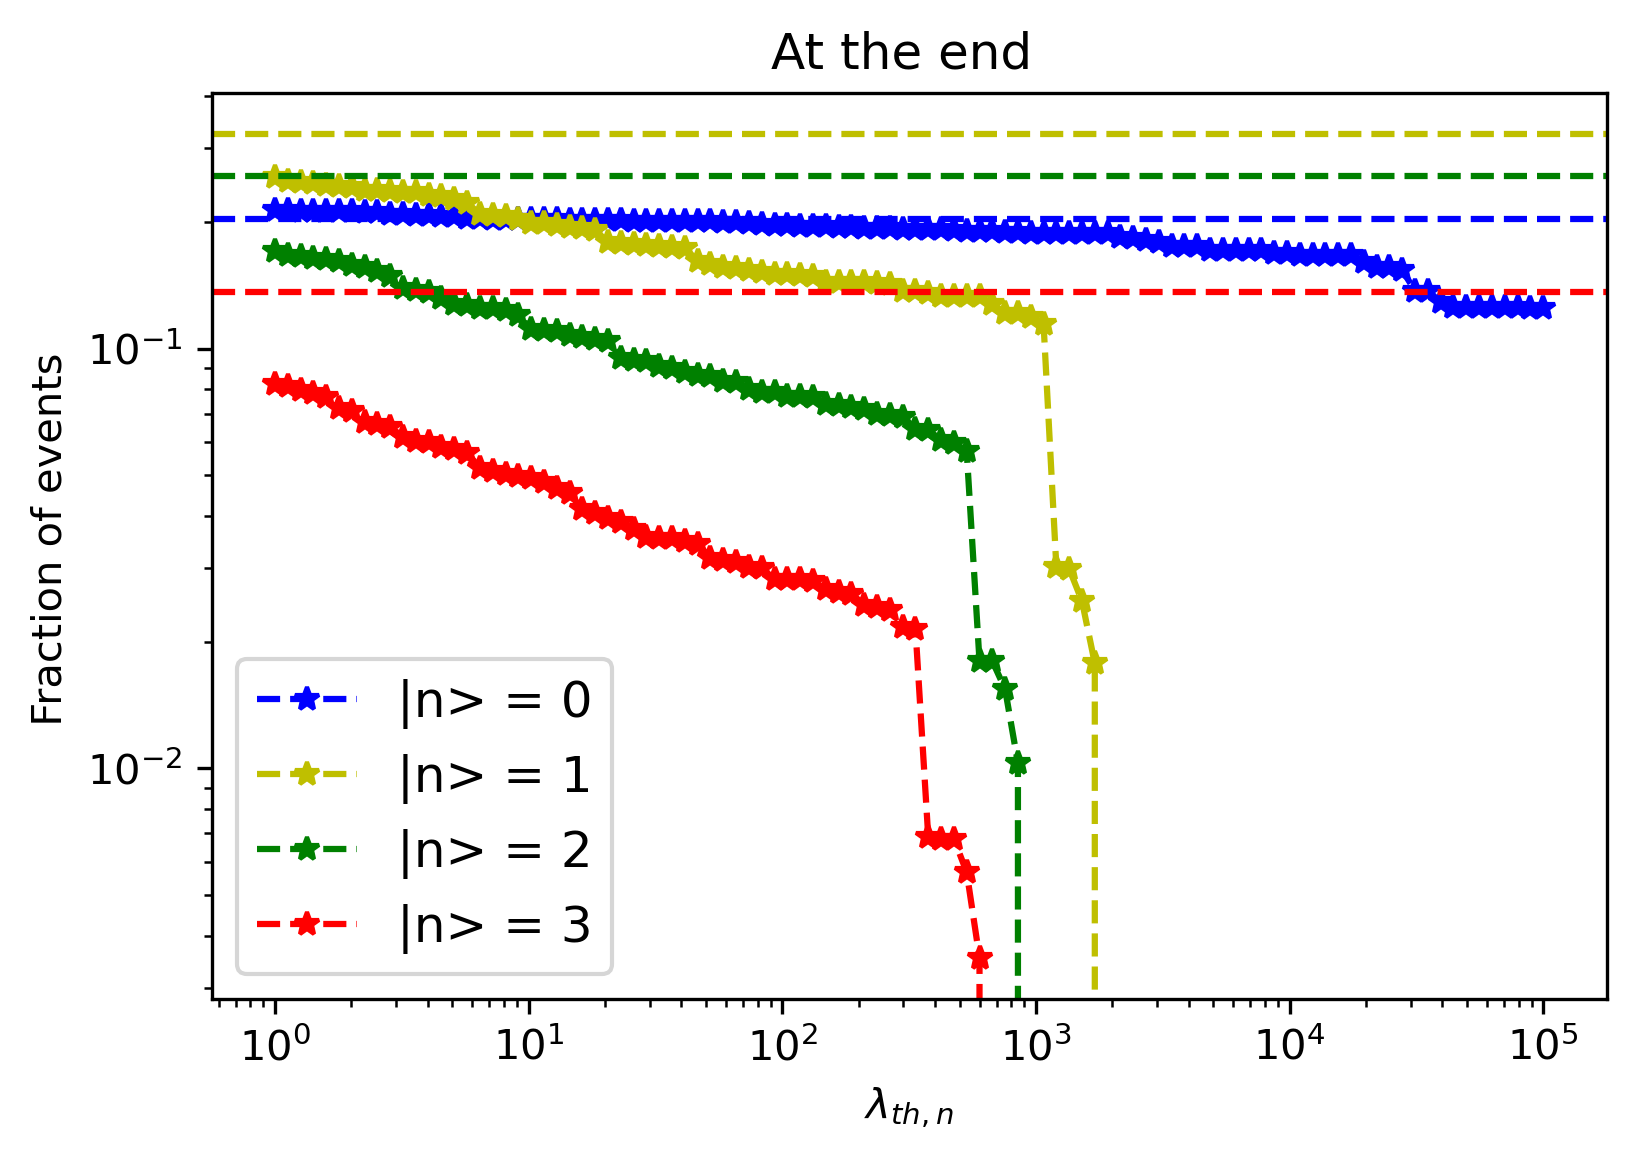

In [5]:
p_m_counts = []
p_n_counts = []
camp = 0.0

for fock_state in range(4):
    
    data_path = 'n' + str(fock_state)+'//'
    inj_path = 'n' + str(fock_state)+'//injected_photon//'

    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(camp)+".h5"
    print(filename)
    
    with File(filename, 'r')as a:
        p_m = np.array(a['p_m_counts'])
        p_n = np.array(a['p_n_counts'])
    
    p_m_counts.append(p_m)
    p_n_counts.append(p_n)
    
dm_end = pd.DataFrame(p_m_counts)
dn_end = pd.DataFrame(p_n_counts)

th_m = np.logspace(0, 5, 100)
th_n = np.logspace(0, 5, 100)

count_m = {}
count_n = {}
plt.figure(dpi=300)
colors = ['b', 'y', 'g', 'r']
for ii in range(len(dm_end)):
    plt.axhline(y = exp_pop[ii], linestyle='--', color=colors[ii])
    ct_m = []
    for th in th_m:
        ct_m.append(dm_end.iloc[ii][dm_end.iloc[ii]>th].count()/50000)
    plt.loglog(th_m, ct_m, '*--', label='|n> = %i'%ii, color=colors[ii])
    count_m['n%i'%ii] = ct_m
plt.legend(fontsize=12)
plt.title('At the end ')
plt.xlabel(r'$\lambda_{th, n}$')
plt.ylabel(' Fraction of events')
plt.show()

In [18]:
h = 20
print(th_m[h], count_m['n1'][h]/exp_pop[1])

10.235310218990262 0.6139522601050377


n0//injected_photon//n0_camp_0.0_begin.h5
n1//injected_photon//n1_camp_0.0_begin.h5
n2//injected_photon//n2_camp_0.0_begin.h5
n3//injected_photon//n3_camp_0.0_begin.h5


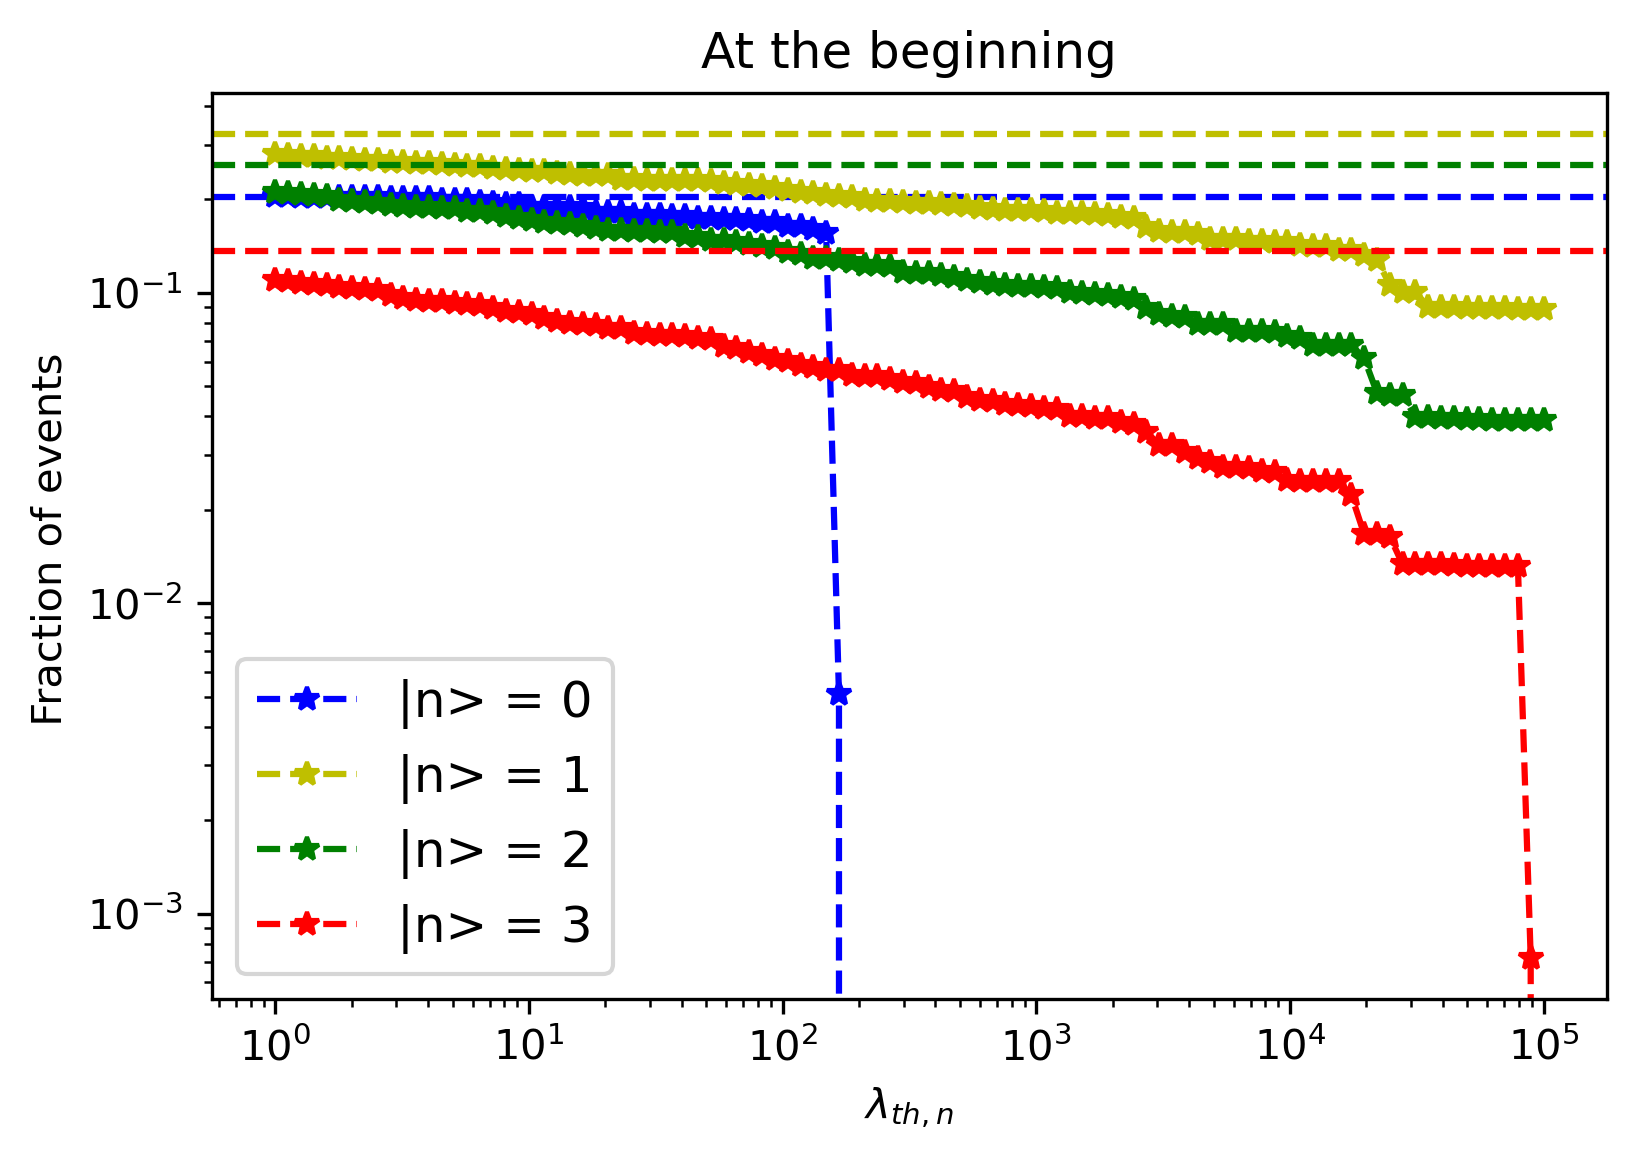

In [17]:
p_m_counts = []
p_n_counts = []
camp = 0.0

for fock_state in range(4):
    
    data_path = 'n' + str(fock_state)+'//'
    inj_path = 'n' + str(fock_state)+'//injected_photon//'

    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+"_begin.h5"
    print(filename)
    
    with File(filename, 'r')as a:
        p_m = np.array(a['p_m_counts'])
        p_n = np.array(a['p_n_counts'])
    
    p_m_counts.append(p_m)
    p_n_counts.append(p_n)
    
dm_begin = pd.DataFrame(p_m_counts)
dn_begin = pd.DataFrame(p_n_counts)

th_m = np.logspace(0, 5, 100)
th_n = np.logspace(0, 5, 100)

count_m = {}
count_n = {}
plt.figure(dpi=300)
colors = ['b', 'y', 'g', 'r']
for ii in range(len(dm_begin)):
    plt.axhline(y = exp_pop[ii], linestyle='--', color=colors[ii])
    ct_m = []
    for th in th_m:
        ct_m.append(dm_begin.iloc[ii][dm_begin.iloc[ii]>th].count()/50000)
    plt.loglog(th_m, ct_m, '*--', label='|n> = %i'%ii, color=colors[ii])
    count_m['n%i'%ii] = ct_m
plt.legend(fontsize=12)
plt.title('At the beginning')
plt.xlabel(r'$\lambda_{th, n}$')
plt.ylabel(' Fraction of events')
plt.show()

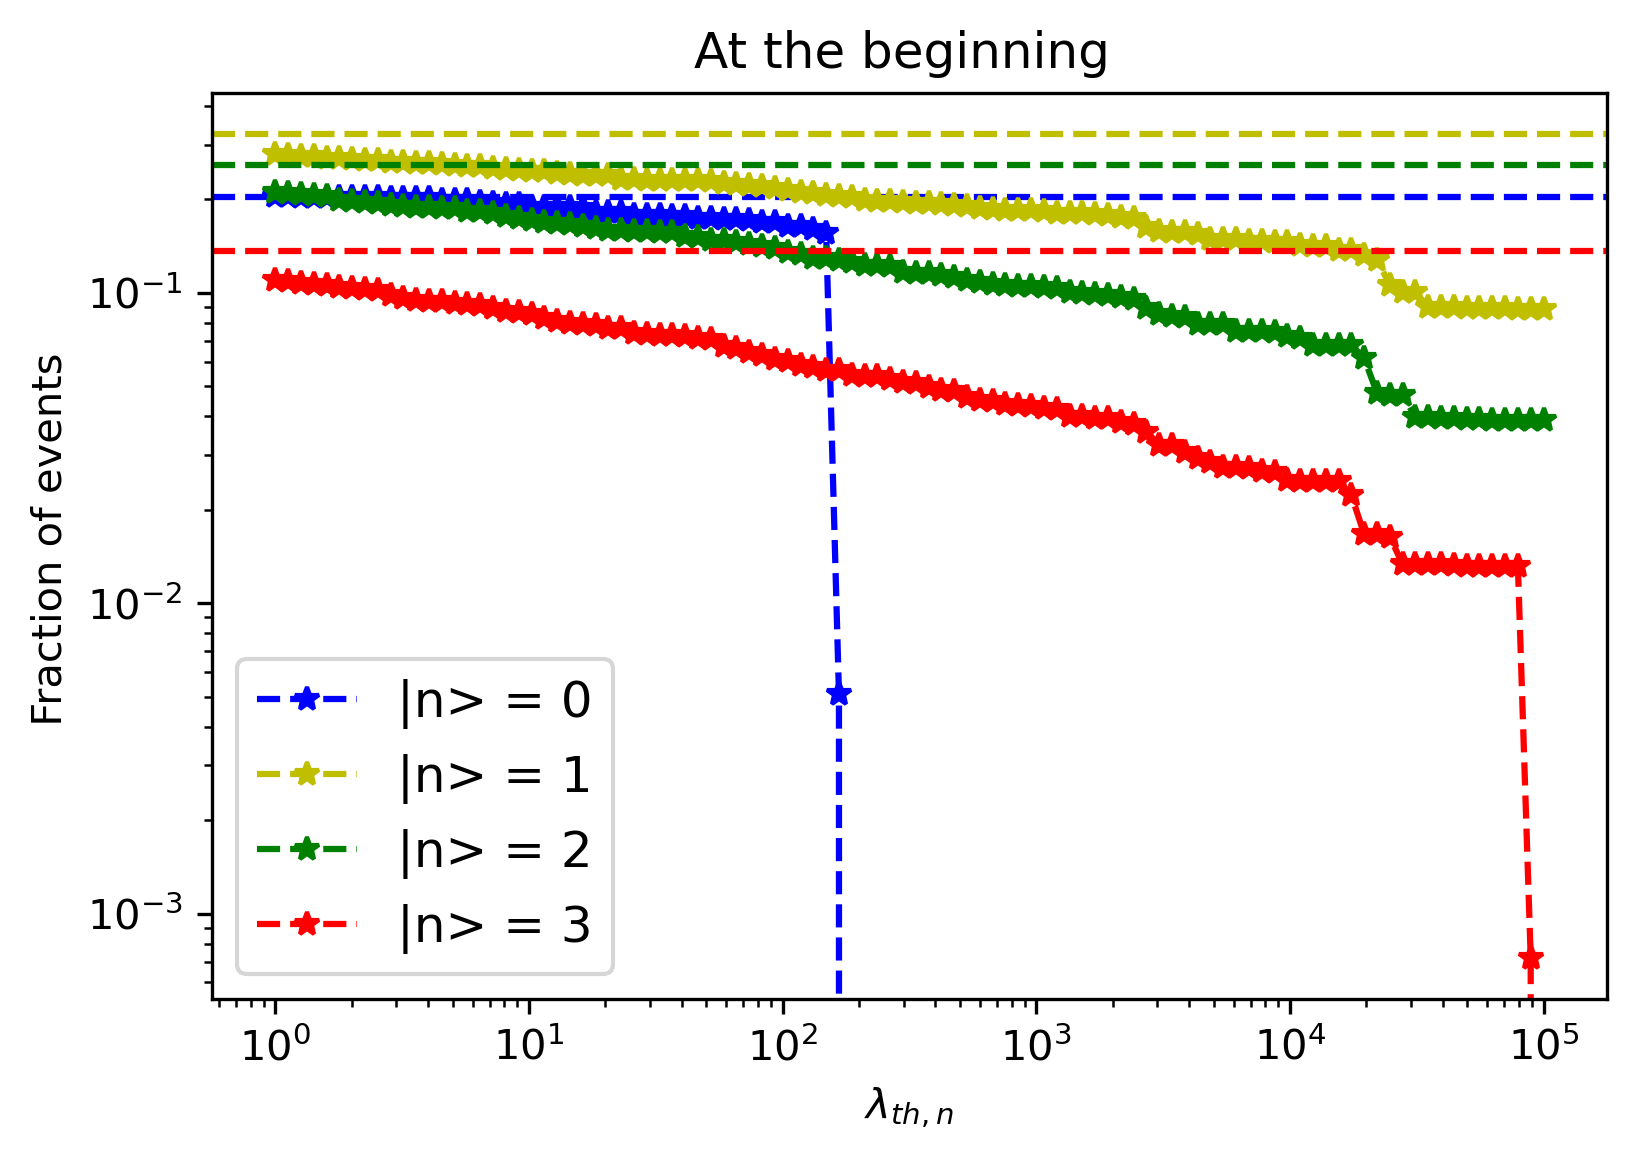

In [9]:
dm = pd.DataFrame(p_m_counts)
dn = pd.DataFrame(p_n_counts)

th_m = np.logspace(0, 5, 100)
th_n = np.logspace(0, 5, 100)

count_m = {}
count_n = {}
plt.figure(dpi=300)
colors = ['b', 'y', 'g', 'r']
for ii in range(len(dm)):
    plt.axhline(y = exp_pop[ii], linestyle='--', color=colors[ii])
    ct_m = []
    for th in th_m:
        ct_m.append(dm.iloc[ii][dm.iloc[ii]>th].count()/50000)
    plt.loglog(th_m, ct_m, '*--', label='|n> = %i'%ii, color=colors[ii])
    count_m['n%i'%ii] = ct_m
plt.legend(fontsize=12)
plt.title('At the beginning ')
plt.xlabel(r'$\lambda_{th, n}$')
plt.ylabel(' Fraction of events')
plt.show()

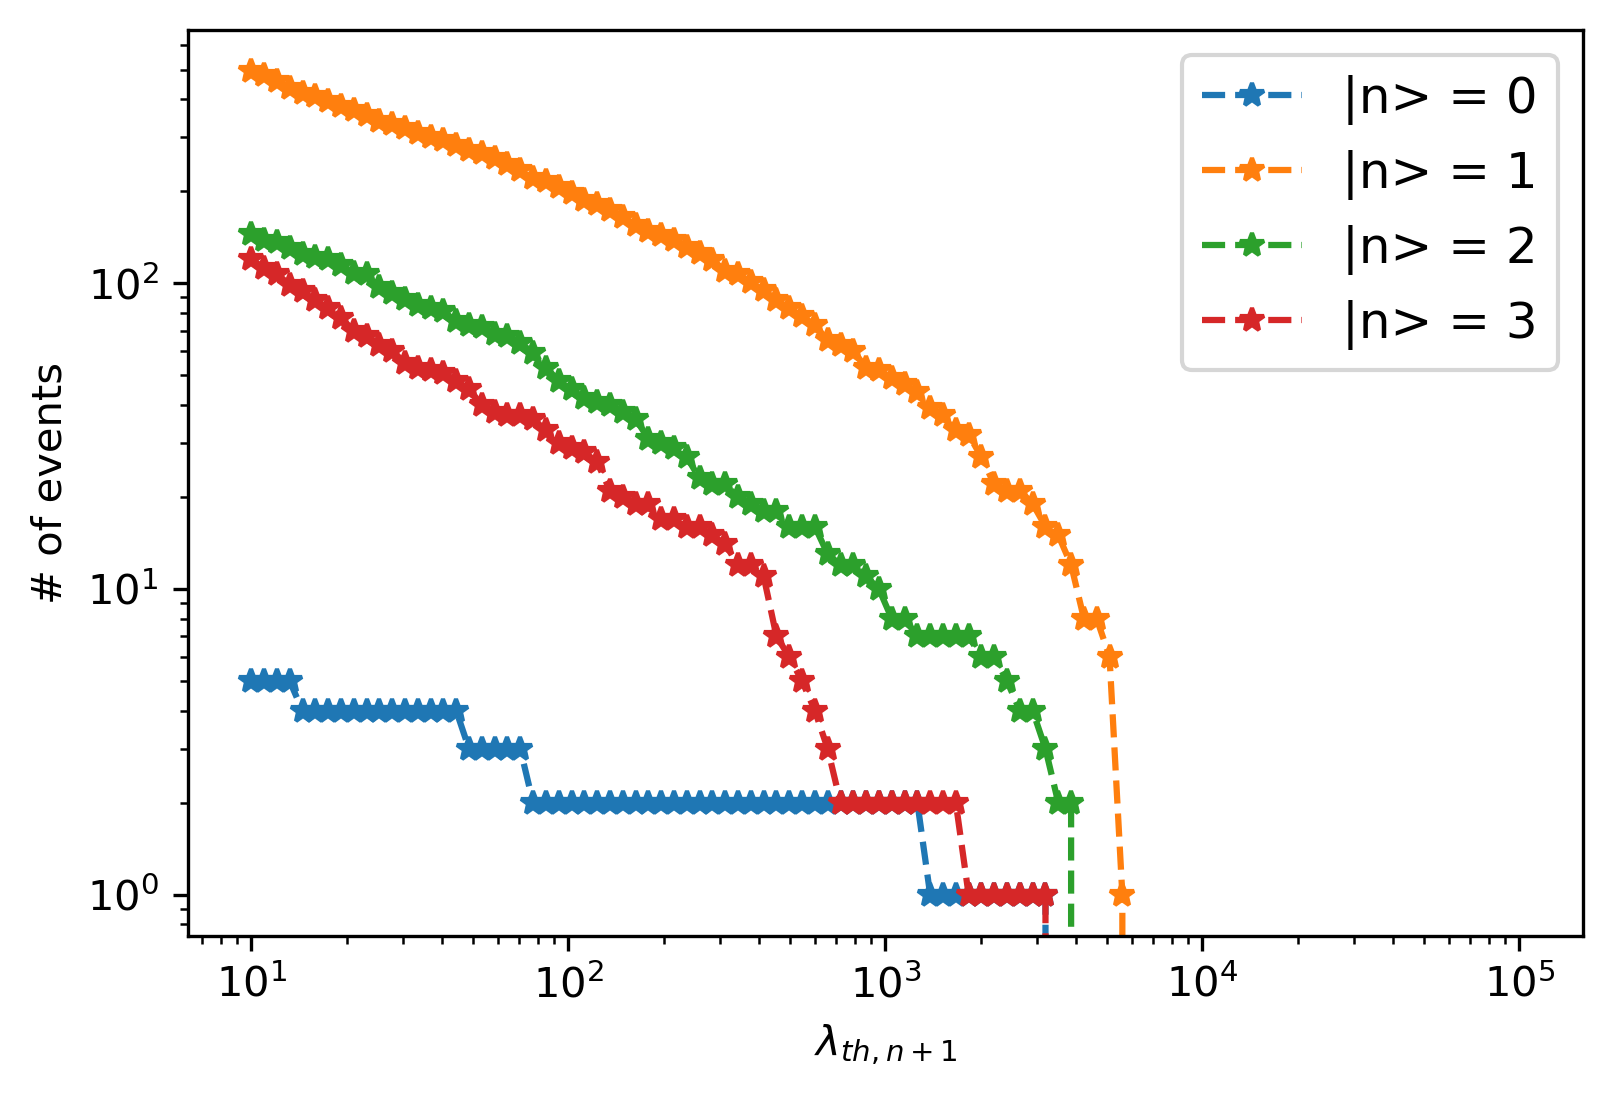

In [285]:
dm = pd.DataFrame(p_m_counts)
dn = pd.DataFrame(p_n_counts)

th_m = np.logspace(1, 5, 100)
th_n = np.logspace(1, 7, 100)

th1 = [1e4, 1e3, 5e2, 3e2]

count_m = {}
count_n = {}
frac_n = {}
plt.figure(dpi=300)
for ii in range(len(dm)):
    ct_n = []
    for th in th_n:
        ct_n.append(dn.iloc[ii][(dm.iloc[ii]>th1[ii]) & (dn.iloc[ii]>th)].count())
    plt.loglog(th_m, ct_n, '*--', label='|n> = %i'%ii)
    count_n['n%i'%ii] = ct_n
    ct_m = dm.iloc[ii][dm.iloc[ii]>th1[ii]].count()
    frac_n['n%i'%ii] = ct_n/ct_m
plt.legend(fontsize=12)
plt.xlabel(r'$\lambda_{th, n+1}$')
plt.ylabel('# of events')
plt.show()

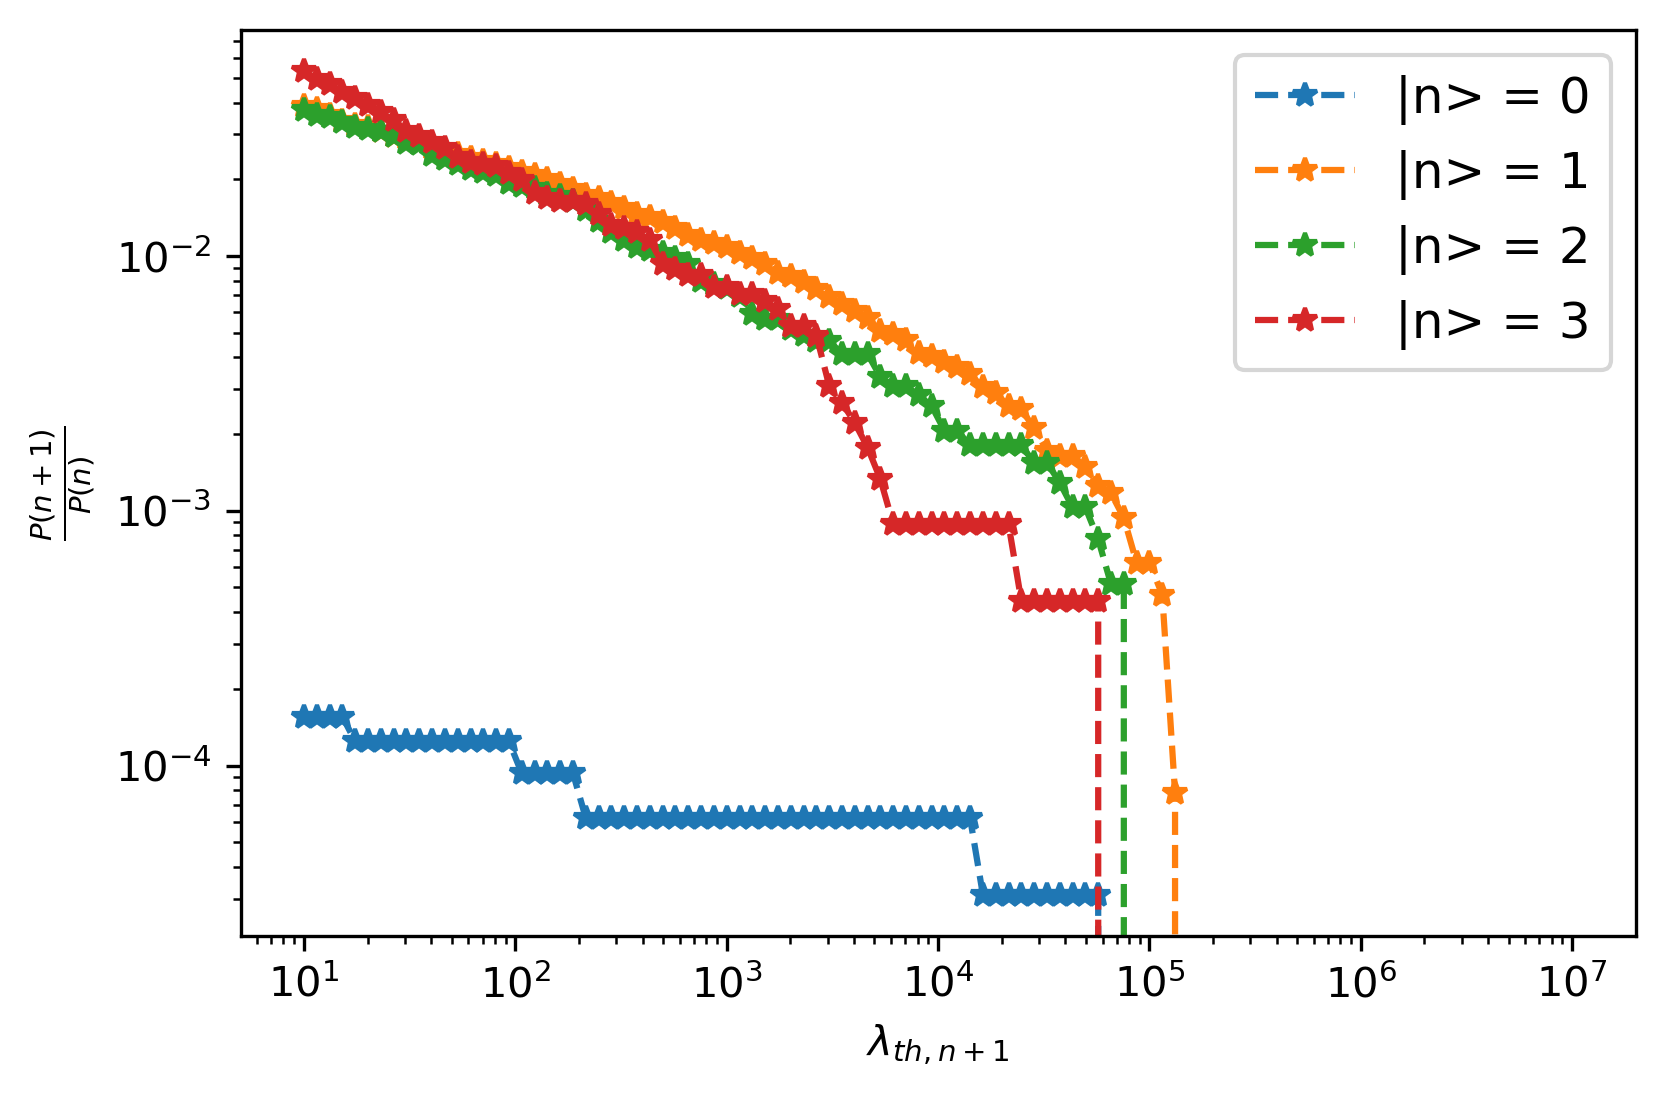

In [286]:
plt.figure(dpi=300)

for ii in range(len(dm)):
    plt.loglog(th_n, frac_n['n%i'%ii], '*--', label='|n> = %i'%ii)
plt.legend(fontsize=12)
plt.xlabel(r'$\lambda_{th, n+1}$')
plt.ylabel(r'$\frac{P(n+1)}{P(n)}$')
# plt.ylim(1e-2, 1)
plt.show()

## Function of number of pi pulses

In [20]:
import json
filename = '00000_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = 0.0
for fock_state in range(4):
    
    data_path = 'n' + str(fock_state)+'//'
    inj_path = 'n' + str(fock_state)+'//injected_photon//'

    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []

    filename = data_path+filelist[0]
    for ii in range(1, 10, 1):
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, 
                                             fstate_in=fock_state, inc_pi_pulse=ii)
        p_m_counts.append(p_m)
        p_n_counts.append(p_n)
    
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+"_npi.h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_m_counts)
        f.create_dataset("alpha", data = alpha)
        f.create_dataset("npi_pulse", data = np.arange(1, 10, 1))        
        f.close()


['00000_stim_em_n0_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
n0//injected_photon//n0_camp_0.0_npi.h5
['00000_stim_em_n1_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0

n0//injected_photon//n0_camp_0.0_npi.h5
n1//injected_photon//n1_camp_0.0_npi.h5
n2//injected_photon//n2_camp_0.0_npi.h5
n3//injected_photon//n3_camp_0.0_npi.h5
(4, 9, 50000)


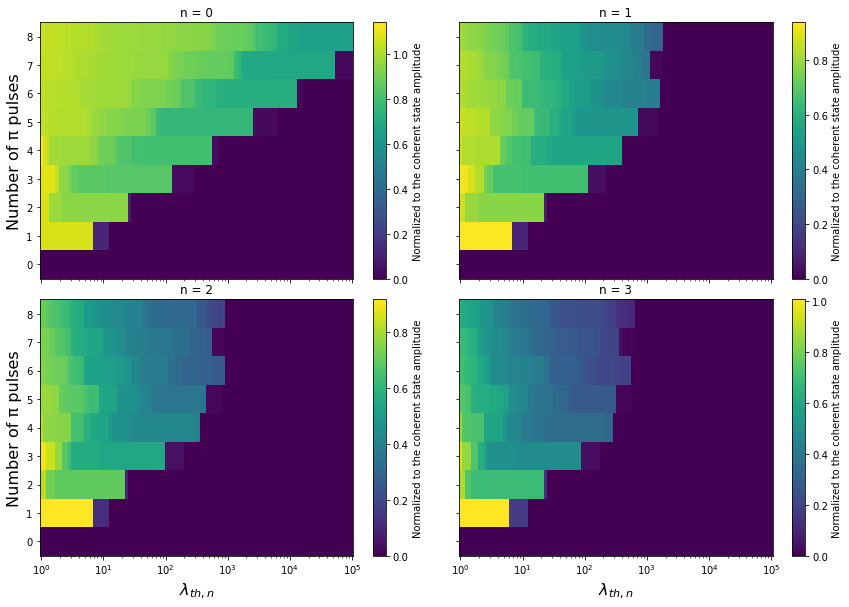

In [76]:
p_m_counts = []
p_n_counts = []
camp = 0.0

for fock_state in range(4):
    
    data_path = 'n' + str(fock_state)+'//'
    inj_path = 'n' + str(fock_state)+'//injected_photon//'

    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+"_npi.h5"
    print(filename)
    
    with File(filename, 'r')as a:
        p_m = np.array(a['p_m_counts'])
        p_n = np.array(a['p_n_counts'])
    
    p_m_counts.append(p_m)
    p_n_counts.append(p_n)

print(np.shape(p_m_counts))
nx, ny, nz = np.shape(p_m_counts)
th_m = np.logspace(0, 5, 100)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)
plt.tight_layout()
for ii in range(nx):
    df = pd.DataFrame(p_m_counts[ii])
    ct_m = []
    for jj in range(ny):
        temp = []
        for th in th_m:
            temp.append(df.iloc[jj][df.iloc[jj]>th].count()/50000)
        ct_m.append(temp)
    im = axs[ii//2, ii%2].pcolormesh(th_m, range(ny), ct_m/exp_pop[ii], shading='auto')
    colorbar(im, ax=axs[ii//2, ii%2], label='Normalized to the coherent state amplitude')
    cbar.set_label('P')
    axs[ii//2, ii%2].set_title('n = %i'%ii)
    axs[ii//2, ii%2].set_xscale('log')
    axs[1, ii%2].set_xlabel(r'$\lambda_{th, n}$', fontsize=16)
    axs[ii%2, 0].set_ylabel('Number of π pulses', fontsize=16)
plt.show()

n0//injected_photon//n0_camp_0.0_npi.h5
n1//injected_photon//n1_camp_0.0_npi.h5
n2//injected_photon//n2_camp_0.0_npi.h5
n3//injected_photon//n3_camp_0.0_npi.h5
(4, 9, 50000)


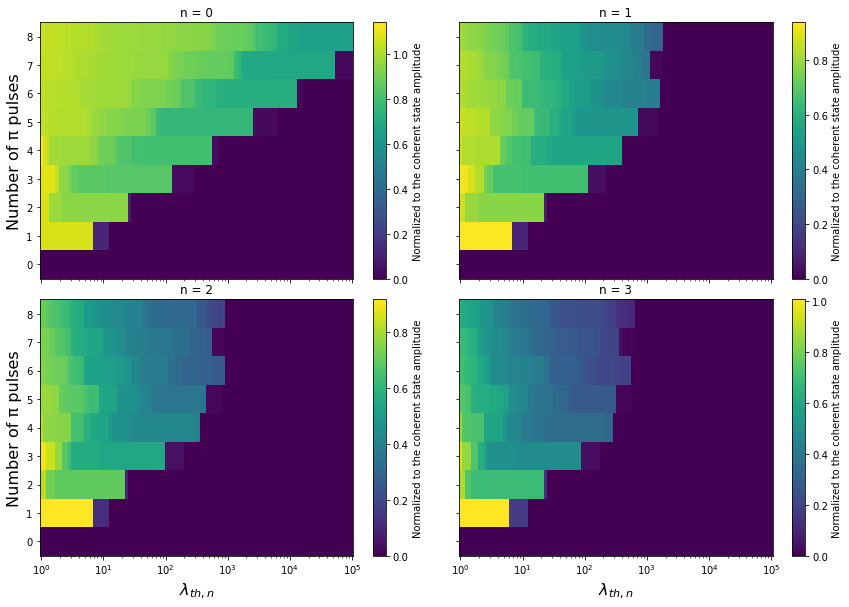

In [109]:
p_m_counts = []
p_n_counts = []
camp = 0.0

for fock_state in range(4):
    
    data_path = 'n' + str(fock_state)+'//'
    inj_path = 'n' + str(fock_state)+'//injected_photon//'

    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+"_npi.h5"
    print(filename)
    
    with File(filename, 'r')as a:
        p_m = np.array(a['p_m_counts'])
        p_n = np.array(a['p_n_counts'])
    
    p_m_counts.append(p_m)
    p_n_counts.append(p_n)

print(np.shape(p_m_counts))
nx, ny, nz = np.shape(p_m_counts)
th_m = np.logspace(0, 5, 100)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)
plt.tight_layout()
for ii in range(nx):
    df = pd.DataFrame(p_m_counts[ii])
    ct_m = []
    for jj in range(ny):
        temp = []
        for th in th_m:
            temp.append(df.iloc[jj][df.iloc[jj]>th].count()/50000)
        ct_m.append(temp)
    im = axs[ii//2, ii%2].pcolormesh(th_m, range(ny), ct_m/exp_pop[ii], shading='auto')
    colorbar(im, ax=axs[ii//2, ii%2], label='Normalized to the coherent state amplitude')
    cbar.set_label('P')
    axs[ii//2, ii%2].set_title('n = %i'%ii)
    axs[ii//2, ii%2].set_xscale('log')
    axs[1, ii%2].set_xlabel(r'$\lambda_{th, n}$', fontsize=16)
    axs[ii%2, 0].set_ylabel('Number of π pulses', fontsize=16)
plt.show()

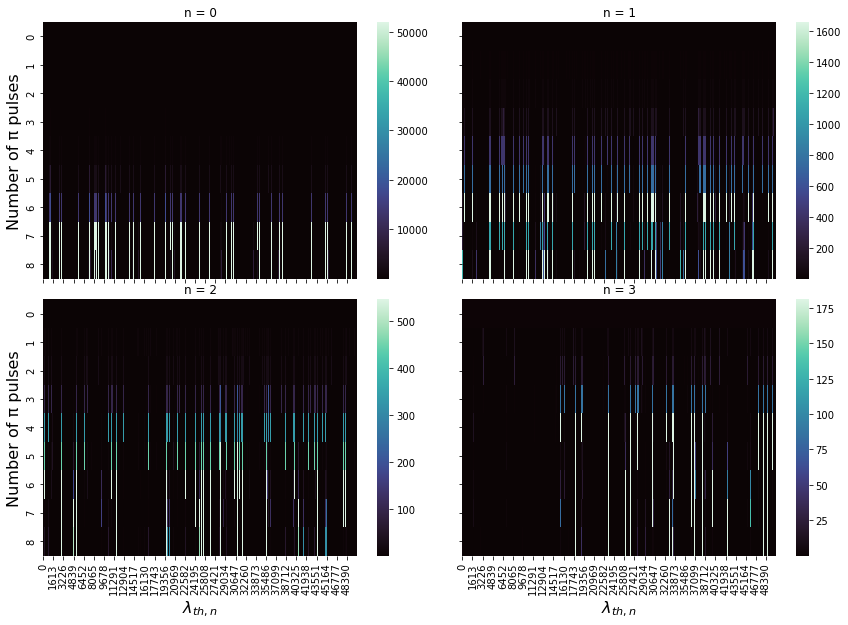

In [135]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)
plt.tight_layout()

for ii in range(nx):
    ax = axs[ii//2, ii%2]
    sns.heatmap(p_m_counts[ii], ax=ax,  robust=True, cmap='mako')
    ax.set_title('n = %i'%ii)
    axs[1, ii%2].set_xlabel(r'$\lambda_{th, n}$', fontsize=16)
    axs[ii%2, 0].set_ylabel('Number of π pulses', fontsize=16)
plt.show()

n0//injected_photon//n0_camp_0.0_npi.h5
n1//injected_photon//n1_camp_0.0_npi.h5
n2//injected_photon//n2_camp_0.0_npi.h5
n3//injected_photon//n3_camp_0.0_npi.h5
(4, 9, 50000)


<ipython-input-162-abe6cb1de59a>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axs[ii//2, ii%2].pcolormesh(temp[1], range(1, ny+1, 1), Z, shading='auto', cmap='mako', norm=matplotlib.colors.LogNorm())


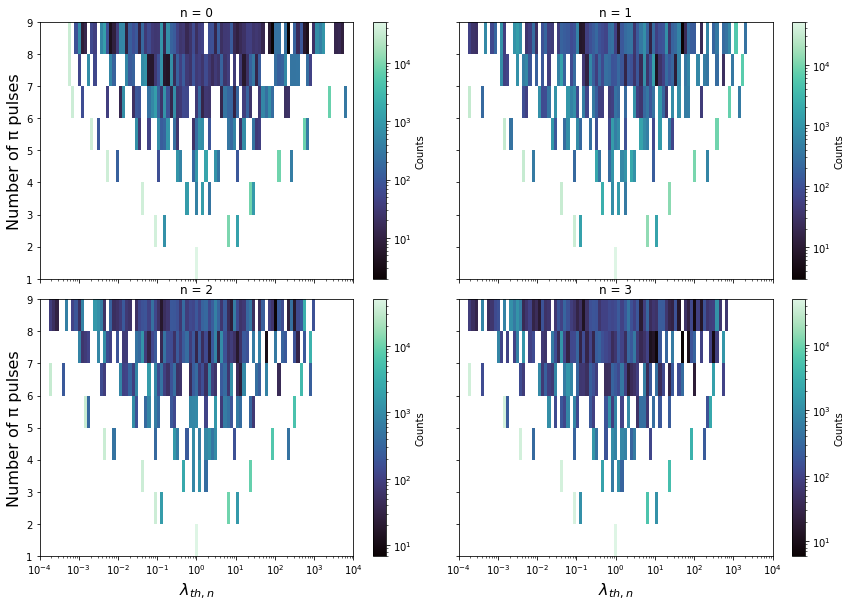

In [162]:
import matplotlib.colors
from matplotlib.ticker import LogFormatter 

p_m_counts = []
p_n_counts = []
camp = 0.0

for fock_state in range(4):
    
    data_path = 'n' + str(fock_state)+'//'
    inj_path = 'n' + str(fock_state)+'//injected_photon//'

    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+"_npi.h5"
    print(filename)
    
    with File(filename, 'r')as a:
        p_m = np.array(a['p_m_counts'])
        p_n = np.array(a['p_n_counts'])
    
    p_m_counts.append(p_m)
    p_n_counts.append(p_n)

print(np.shape(p_m_counts))
nx, ny, nz = np.shape(p_m_counts)
th_m = np.logspace(-4, 4, 100)

hist_data = []


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)
plt.tight_layout()
for ii in range(nx):
    df = pd.DataFrame(p_m_counts[ii])
    ct_m = []
    for jj in range(ny):
        temp = np.histogram(df.iloc[jj], bins=th_m)
        ct_m.append(temp[0])
    Z = np.array(ct_m)
    im = axs[ii//2, ii%2].pcolormesh(temp[1], range(1, ny+1, 1), Z, shading='auto', cmap='mako', norm=matplotlib.colors.LogNorm())
    colorbar(im, ax=axs[ii//2, ii%2], label='Counts')
    axs[ii//2, ii%2].set_title('n = %i'%ii)
    axs[ii//2, ii%2].set_xscale('log')
    axs[1, ii%2].set_xlabel(r'$\lambda_{th, n}$', fontsize=16)
    axs[ii%2, 0].set_ylabel('Number of π pulses', fontsize=16)
plt.show()

In [53]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[18859, 18540, 18008, 15996], [18859, 18540, 18008, 15996], [18859, 18540, 18008, 15996], [18859, 18540, 18008, 15996], [18859, 18540, 18008, 15996]]


In [72]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[18201, 16516, 14248, 0], [18201, 16516, 14248, 0], [18201, 16516, 14248, 0], [18201, 16516, 14248, 0], [18201, 16516, 14248, 0]]


In [6]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[3853, 534, 419, 0], [3853, 534, 419, 0], [3853, 534, 419, 0], [3853, 534, 419, 0], [3853, 534, 419, 0]]


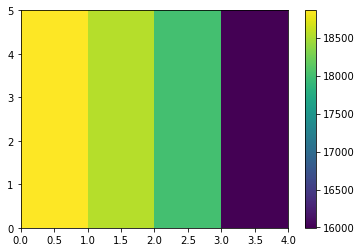

In [55]:
plt.pcolormesh( count_m, shading='auto')
plt.colorbar()
# plt.xscale('log')
plt.show()

In [27]:
th1 = 1e3
th2 = 1e4

df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

count_m = df['p_m'][df['p_m']>th1].count()
print(count_m)
count_n = df['p_n'][df['p_n']>th2].count()
print(count_n)

count_p = df['p_n'][(df['p_m']>th1) & (df['p_n']>th2)].count()

print(count_p, count_p/count_m)

18008
13
1 5.553087516659262e-05


In [79]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 1

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

cav_nth = np.arange(0.0, 0.001, 0.0002)

p_m_counts = []
p_n_counts = []

for nth in cav_nth[:1]:
    
    readout_params['nth'] = nth
    camp = 0.0
    data_path = 'n'+ str(fock_state)+'//'
    
    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.append(p_m)
        p_n_counts.append(p_n)

['00000_stim_em_n1_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns


In [26]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 5, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[11402, 9434, 7454, 4307]]


In [83]:
df = pd.DataFrame({'p_m': p_m_counts[0], 'p_n': p_n_counts[0]})

print(np.shape(df))
th1 = 1e3
th2 = 1e5

count_m = df['p_m'][df['p_m']>th1].count()
print(count_m)
count_p = df['p_n'][(df['p_m']>th1) & (df['p_n']>th2)].count()
print(count_p)

(20000, 2)
6498
1


In [ ]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 5, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

In [71]:
df = pd.DataFrame({'p_m': p_m_counts[0], 'p_n': p_n_counts[0]})

print(np.shape(df))
th1 = 1e3
th2 = 1e4

count_m = df['p_m'][df['p_m']>th1].count()
print(count_m)
count_p = df['p_n'][(df['p_m']>th1) & (df['p_n']>th2)].count()
print(count_p)

(20000, 2)
6498
24


In [72]:
1-np.exp(-7/1240)

0.005629257308246927

In [61]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0]]


In [74]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0], [9384, 7075, 5548, 0]]


In [84]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 3

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

cav_nth = np.arange(0.0, 0.001, 0.0002)

p_m_counts = []
p_n_counts = []

for nth in cav_nth[:1]:
    
    readout_params['nth'] = nth
    camp = 0.0
    data_path = 'n'+ str(fock_state)+'//'
    
    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.append(p_m)
        p_n_counts.append(p_n)

['00000_stim_em_n3_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns


In [31]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 5, 5)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[8388, 6025, 3805, 2090, 812]]


In [90]:
df = pd.DataFrame({'p_m': p_m_counts[0], 'p_n': p_n_counts[0]})

print(np.shape(df))
th1 = 1e2
th2 = 6e4

count_m = df['p_m'][df['p_m']>th1].count()
print(count_m)
count_p = df['p_n'][(df['p_m']>th1) & (df['p_n']>th2)].count()
print(count_p)

(20000, 2)
3052
1


In [76]:
2/3052

0.000655307994757536

In [76]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 5, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[4723, 2574, 0, 0], [4723, 2574, 0, 0], [4723, 2574, 0, 0], [4723, 2574, 0, 0], [4723, 2574, 0, 0]]


In [92]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 2

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

cav_nth = np.arange(0.0, 0.001, 0.0002)

p_m_counts = []
p_n_counts = []

for nth in cav_nth[:1]:
    
    readout_params['nth'] = nth
    camp = 0.0
    data_path = 'n'+ str(fock_state)+'//'
    
    filelist = [f for f in os.listdir(data_path) if str(camp)+'_' in f ]
    print(filelist)
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.append(p_m)
        p_n_counts.append(p_n)

['00000_stim_em_n2_camp_0.0_len_10.h5']
# of π at m= 10, at n = 30
Coherent drive: amp = 0.0, length = 10 ns


In [65]:
df = pd.DataFrame(p_m_counts)
th_m = np.logspace(1, 4, 4)
count_m = []
for ii in range(len(p_m_counts)):
    temp = []
    for th1 in (th_m): 
        temp.append(df.iloc[ii][df.iloc[ii]>th1].count())
    count_m.append(temp)
print(count_m)

[[5593, 4053, 0, 0], [5593, 4053, 0, 0], [5593, 4053, 0, 0], [5593, 4053, 0, 0], [5593, 4053, 0, 0]]


In [106]:
df = pd.DataFrame({'p_m': p_m_counts[0], 'p_n': p_n_counts[0]})

print(np.shape(df))
th1 = 5e2
th2 = 7e4

count_m = df['p_m'][df['p_m']>th1].count()
print(count_m)
count_p = df['p_n'][(df['p_m']>th1) & (df['p_n']>th2)].count()
print(count_p)

(20000, 2)
3881
2


In [109]:
1/(5e2+1)

0.001996007984031936

In [114]:
(np.exp(-7.2*2/1400))/((1-np.exp(-7.2*2/1400)))

96.72307936356805

In [116]:
(1-np.exp(-0.24*2/1400))

0.00034279837406359093

In [112]:
(1-np.exp(-7.2*1/1400))

0.005129655294497271

# Stim Em with repeated pi pulses at |n>=0

## Camp = 0.0to 0.9

In [156]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.002).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.10, 0.005).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.2).tolist(), 6))
camp.append(0.0)

fock_state = 0

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n0_camp_0.001_len_10.h5']
n0//00000_stim_em_n0_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n0//injected_photon//n0_camp_0.001.h5
(20000, 2)
18566
17
['00000_stim_em_n0_camp_0.003_len_10.h5']
n0//00000_stim_em_n0_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n0//injected_photon//n0_camp_0.003.h5
(20000, 2)
18521
13
['00000_stim_em_n0_camp_0.005_len_10.h5']
n0//00000_stim_em_n0_camp_0.005_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.005, length = 10 ns
[array(0.00361709)]
n0//injected_photon//n0_camp_0.005.h5
(20000, 2)
18537
24
['00000_stim_em_n0_camp_0.007_len_10.h5']
n0//00000_stim_em_n0_camp_0.007_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.007, length = 10 ns
[array(0.00504764)]
n0//injected_photon//n0_camp_0.007.h5
(20000, 2)
18570
14
['00000_stim_em_n0_camp_0.009_len_10.h5']
n0//00000_stim_em_n0_camp_

### Appending

In [259]:
import json
filename = '00003_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.002).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.10, 0.005).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.2).tolist(), 6))
camp.append(0.0)

fock_state = 0

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
#     print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist[1:]):

        filename = data_path+i
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)
    
    with File(filename, 'r') as f:
        pm_temp = list(f['p_m_counts'])
        pn_temp = list(f['p_n_counts'])
        f.close()
    pm_temp.extend(list(p_m_counts))
    pn_temp.extend(list(p_n_counts))

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=np.array(pm_temp))
        f.create_dataset("p_n_counts", data=np.array(pn_temp))
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': pm_temp, 'p_n': pn_temp})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

n0//00001_stim_em_n0_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n0//injected_photon//n0_camp_0.001.h5
(40000, 2)
37080
33
n0//00001_stim_em_n0_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n0//injected_photon//n0_camp_0.003.h5
(40000, 2)
37111
27
n0//00001_stim_em_n0_camp_0.005_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.005, length = 10 ns
[array(0.00361709)]
n0//injected_photon//n0_camp_0.005.h5
(40000, 2)
37005
39
n0//00001_stim_em_n0_camp_0.007_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.007, length = 10 ns
[array(0.00504764)]
n0//injected_photon//n0_camp_0.007.h5
(40000, 2)
37119
28
n0//00001_stim_em_n0_camp_0.009_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.009, length = 10 ns
[array(0.0067126)]
n0//injected_photon//n0_camp_0.009.h5
(40000, 2)
37042
43
n0//00001_stim_em_n0_camp_0.01_len_10.h5
# of 

In [241]:
fname = 'append_test.h5'
p_m = np.arange(11)
p_n = np.arange(5)

with File(fname, 'w') as f:
    f.create_dataset('p_m', data=p_m)
    f.close()

In [256]:
with File('n0//injected_photon//n0_camp_0.001.h5', 'a') as f:
    p = np.array(f['p_m_counts'])


In [257]:
np.shape(p)

(20000,)

In [258]:
p[1:10]

array([5.71777330e+05, 5.63877263e+03, 5.71777330e+05, 1.86230902e+04,
       5.71777330e+05, 5.71777330e+05, 2.44937102e+02, 5.71777330e+05,
       1.27484103e+06])

In [245]:
with File(fname, 'r') as f:
    data = np.array(f['p_m'])
    print(data)
    f.close()


KeyError: "Unable to open object (object 'p_m' doesn't exist)"

In [204]:
with File(fname, 'r') as f:
    data = np.array(f['p_m'])
    print(data)
    f.close()
with File(fname, 'a') as f:
    f.create_dataset('p_m', data=p_n)
    f.close()
    
with File(fname, 'r') as f:
    data = np.array(f['p_m'])
    print(data)
    f.close()


[ 0  1  2  3  4  5  6  7  8  9 10]


ValueError: Unable to create dataset (name already exists)

In [24]:
filename = 'C:\\_Lib\\python\\slab\\experiments\\qm_opx_mm\\data\\stim_em_oct_rp\\20220122\\n6\\00000_stim_em_n6_camp_0.01_len_10.h5'

In [25]:

with File(filename,'r') as a:
    bit = np.array(a["bit"])

In [225]:
fname = 'append_test.h5'
p_m = np.arange(11)
p_n = np.arange(11)

with SlabFile(fname, 'a') as f:
    f.append_line('p_m',p_m)
    f.close()

In [226]:
with SlabFile(fname, 'a') as f:
    data = np.array(f['p_m'])
    print(data)
    f.close()

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]


In [228]:
with SlabFile(fname, 'a') as f:
    f.append_line('p_m', p_n)

In [229]:
with SlabFile(fname, 'a') as f:
    data = np.array(f['p_m'])
    print(data)
    f.close()

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]


In [230]:
data.flatten()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  0.,  1.,
        2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [240]:
fname = 'n0_camp_0.001.h5'

with SlabFile(fname,) as f:
    data = np.array(f['p_m_counts'])[:]
    print(np.shape(data))
    f.close()
    
with SlabFile(fname, 'a') as f:
    f.append_line('p_m_counts', data)
    f.close()

with SlabFile(fname) as f:
    data = np.array(f['p_m_counts'])
    print(len(data))


(20000,)


TypeError: Only chunked datasets can be resized

## Photon counter fit

In [269]:
data_path =  "n0/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 1e5
th_n = np.logspace(1, 5, 5)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like[7:]):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n0_camp_0.015.h5
Total number of events collected: 40000, 24329 events crossed $\lambda_{th, n}$ and 1 events crossed $\lambda_{th, n+1}$
n0_camp_0.02.h5
Total number of events collected: 40000, 24285 events crossed $\lambda_{th, n}$ and 3 events crossed $\lambda_{th, n+1}$
n0_camp_0.025.h5
Total number of events collected: 40000, 24226 events crossed $\lambda_{th, n}$ and 7 events crossed $\lambda_{th, n+1}$
n0_camp_0.03.h5
Total number of events collected: 40000, 24195 events crossed $\lambda_{th, n}$ and 6 events crossed $\lambda_{th, n+1}$
n0_camp_0.035.h5
Total number of events collected: 40000, 24267 events crossed $\lambda_{th, n}$ and 11 events crossed $\lambda_{th, n+1}$
n0_camp_0.04.h5
Total number of events collected: 40000, 24236 events crossed $\lambda_{th, n}$ and 10 events crossed $\lambda_{th, n+1}$
n0_camp_0.045.h5
Total number of events collected: 40000, 24248 events crossed $\lambda_{th, n}$ and 14 events crossed $\lambda_{th, n+1}$
n0_camp_0.05.h5
Total number of ev

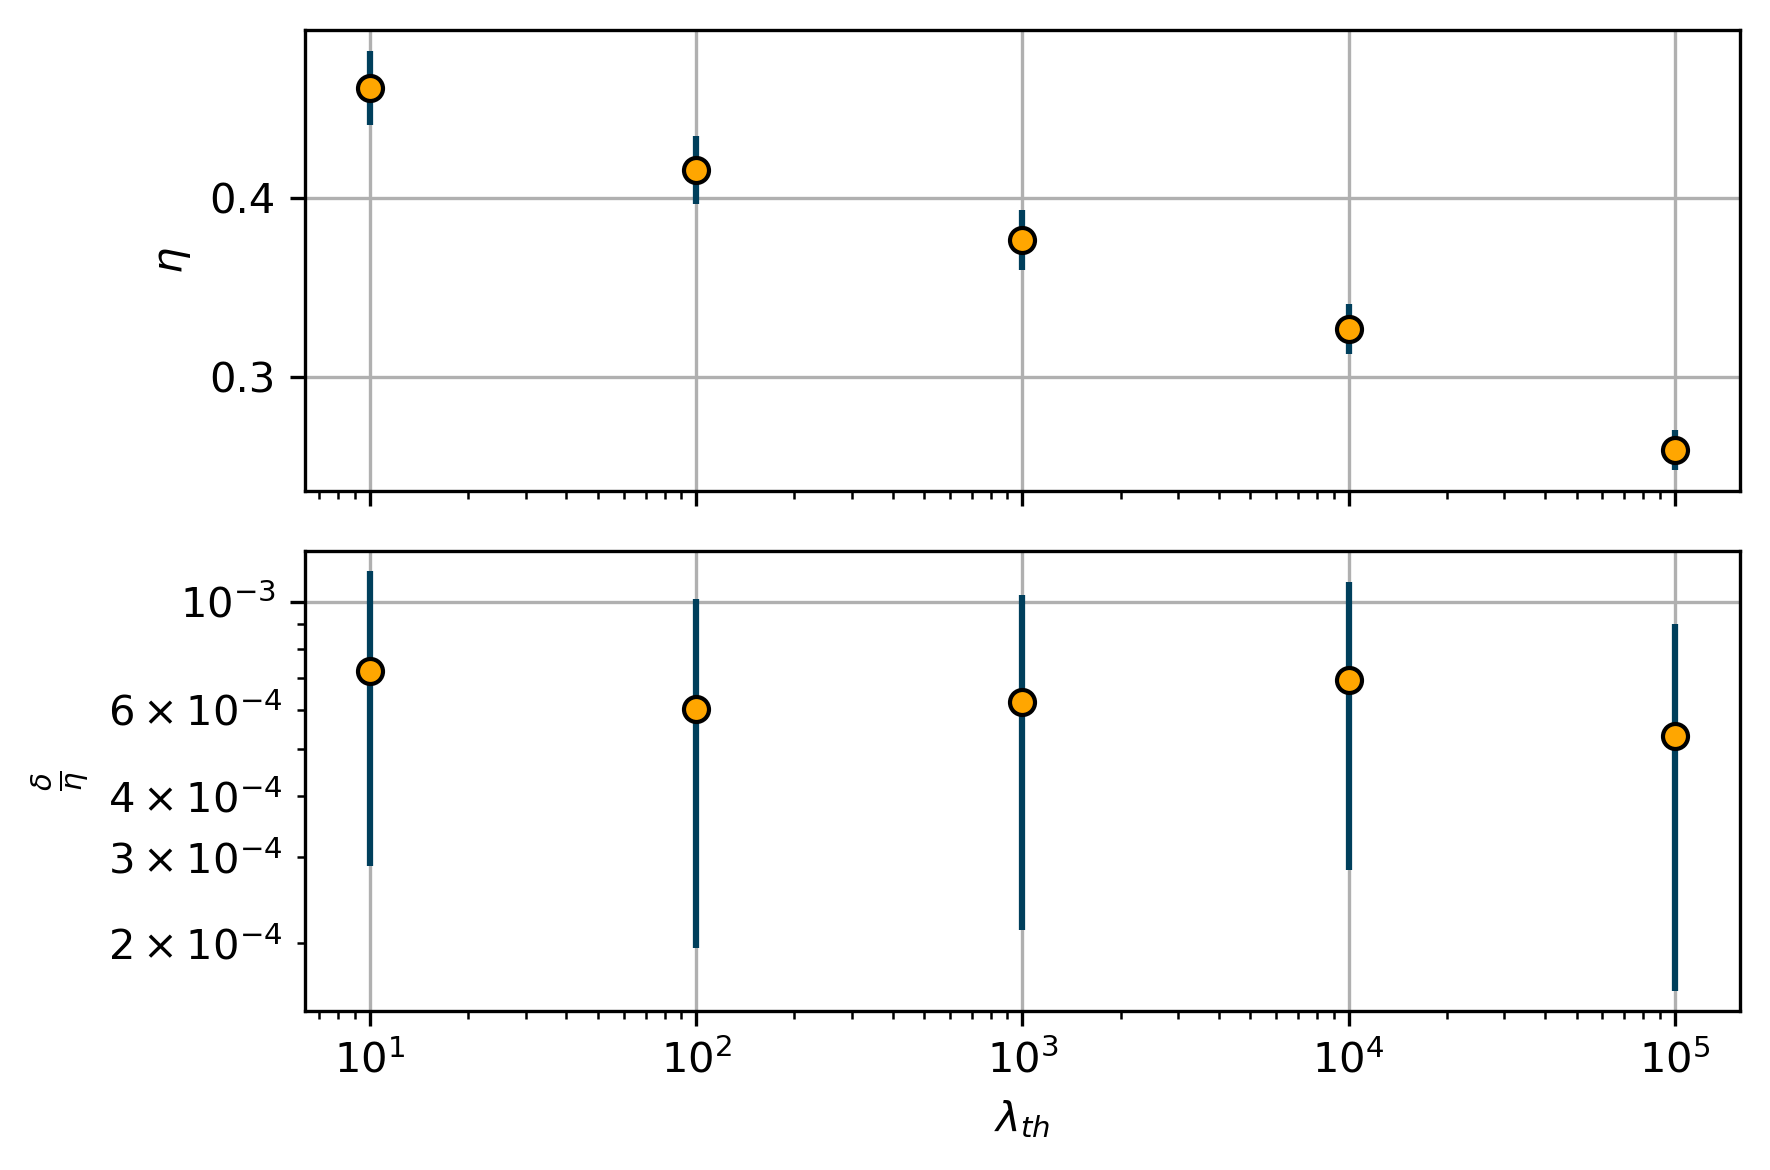

In [270]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.03562


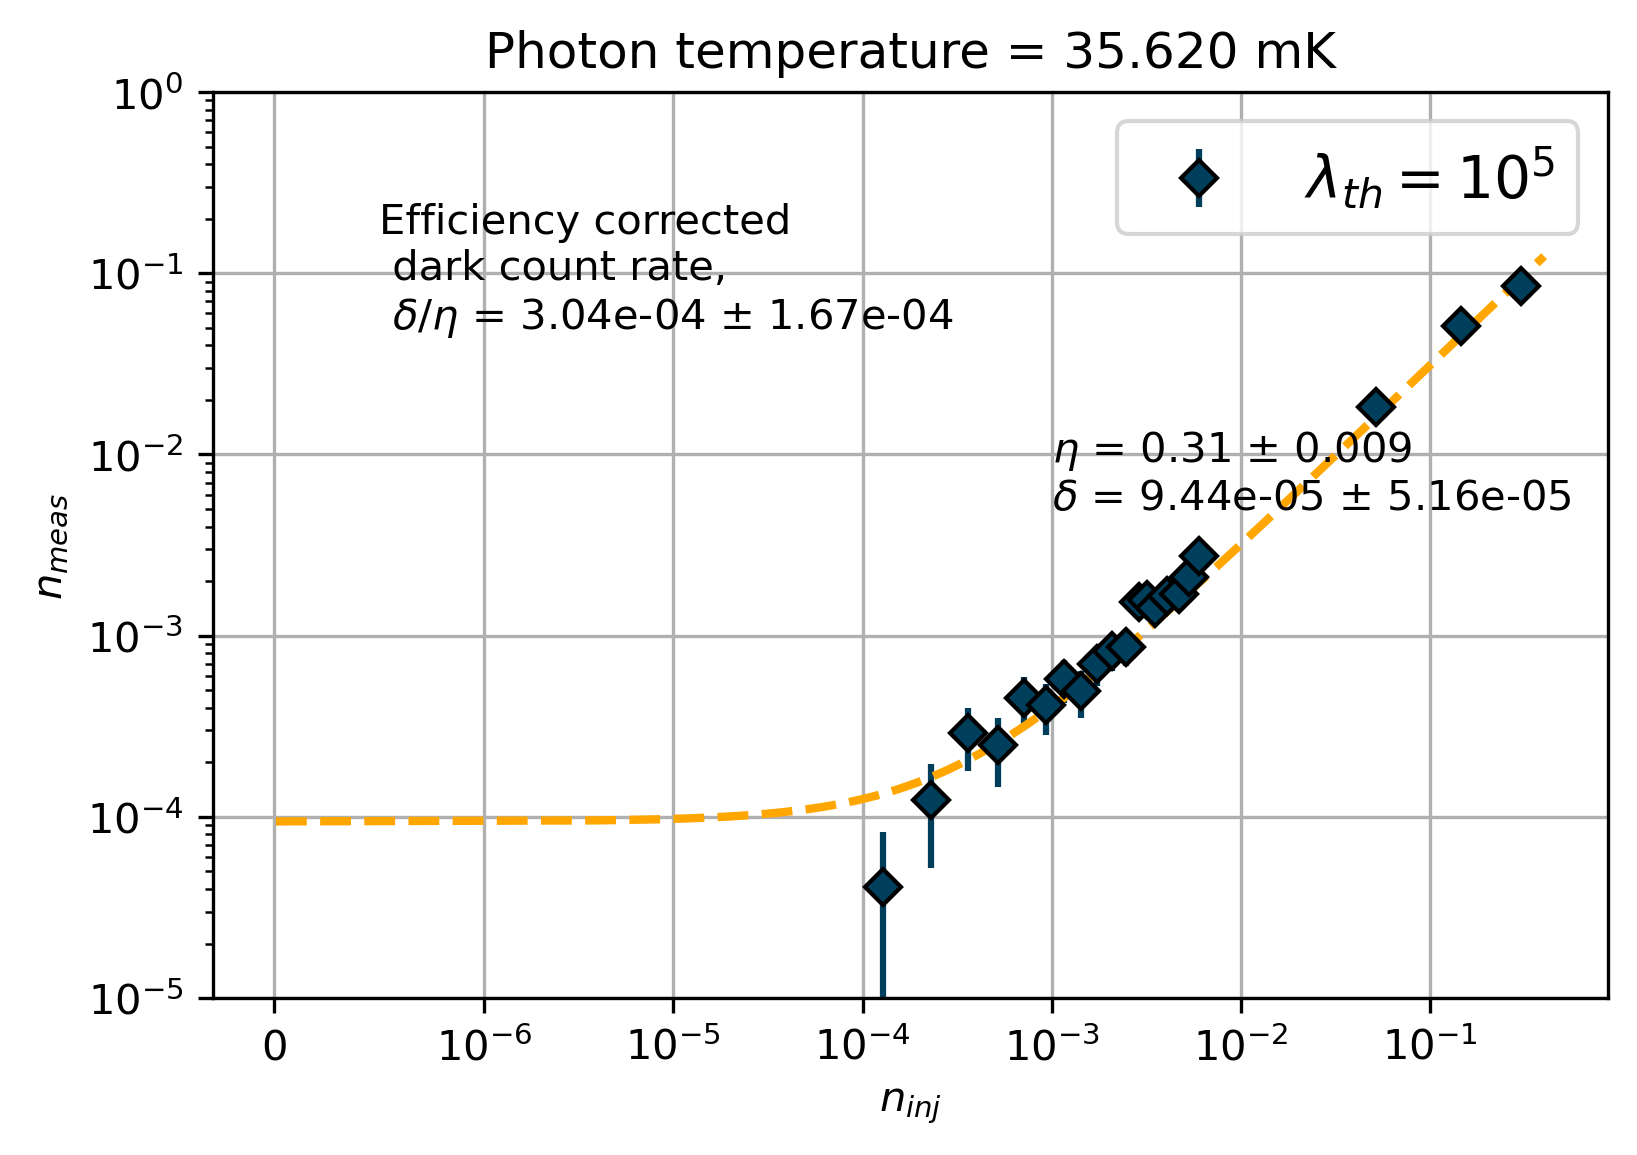

In [271]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
k = 1
plt.figure(dpi=300)
plt.errorbar(n_exp[:-k], y= np.array(y.iloc[-m], dtype=float)[:-k], yerr= np.array(yerr.iloc[-m], dtype=float)[:-k], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp[:-k], ydata=np.array(y.iloc[-m], dtype=float)[:-k], sigma=np.array(yerr.iloc[-m], dtype=float)[:-k], 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-5, 1e0)
plt.text(1e-3, 5e-3, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

# Stim Em with repeated pi pulses at |n> = 1

## Camp = 0.0, cav_len = 400ns

In [157]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.002).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.10, 0.005).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.2).tolist(), 6))
camp.append(0.0)

fock_state = 1

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n1_camp_0.001_len_10.h5']
n1//00000_stim_em_n1_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n1//injected_photon//n1_camp_0.001.h5
(20000, 2)
8165
592
['00000_stim_em_n1_camp_0.003_len_10.h5']
n1//00000_stim_em_n1_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n1//injected_photon//n1_camp_0.003.h5
(20000, 2)
8305
594
['00000_stim_em_n1_camp_0.005_len_10.h5']
n1//00000_stim_em_n1_camp_0.005_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.005, length = 10 ns
[array(0.00361709)]
n1//injected_photon//n1_camp_0.005.h5
(20000, 2)
8085
580
['00000_stim_em_n1_camp_0.007_len_10.h5']
n1//00000_stim_em_n1_camp_0.007_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.007, length = 10 ns
[array(0.00504764)]
n1//injected_photon//n1_camp_0.007.h5
(20000, 2)
8178
602
['00000_stim_em_n1_camp_0.009_len_10.h5']
n1//00000_stim_em_n1_camp_

### Appending

In [260]:
import json
filename = '00003_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.002).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.10, 0.005).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.2).tolist(), 6))
camp.append(0.0)

fock_state = 1

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
#     print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist[1:]):

        filename = data_path+i
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)
    
    with File(filename, 'r') as f:
        pm_temp = list(f['p_m_counts'])
        pn_temp = list(f['p_n_counts'])
        f.close()
    pm_temp.extend(list(p_m_counts))
    pn_temp.extend(list(p_n_counts))

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=np.array(pm_temp))
        f.create_dataset("p_n_counts", data=np.array(pn_temp))
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': pm_temp, 'p_n': pn_temp})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

n1//00001_stim_em_n1_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n1//injected_photon//n1_camp_0.001.h5
(40000, 2)
16249
1109
n1//00001_stim_em_n1_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n1//injected_photon//n1_camp_0.003.h5
(40000, 2)
16383
1125
n1//00001_stim_em_n1_camp_0.005_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.005, length = 10 ns
[array(0.00361709)]
n1//injected_photon//n1_camp_0.005.h5
(40000, 2)
16071
1146
n1//00001_stim_em_n1_camp_0.007_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.007, length = 10 ns
[array(0.00504764)]
n1//injected_photon//n1_camp_0.007.h5
(40000, 2)
16260
1159
n1//00001_stim_em_n1_camp_0.009_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.009, length = 10 ns
[array(0.0067126)]
n1//injected_photon//n1_camp_0.009.h5
(40000, 2)
16328
1171
n1//00001_stim_em_n1_camp_0.01_len_1

## Photon counter line

In [287]:
data_path =  "n1/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 1e3
th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n1_camp_0.0.h5
Total number of events collected: 40000, 12799 events crossed $\lambda_{th, n}$ and 51 events crossed $\lambda_{th, n+1}$
n1_camp_0.001.h5
Total number of events collected: 40000, 12816 events crossed $\lambda_{th, n}$ and 47 events crossed $\lambda_{th, n+1}$
n1_camp_0.003.h5
Total number of events collected: 40000, 12919 events crossed $\lambda_{th, n}$ and 43 events crossed $\lambda_{th, n+1}$
n1_camp_0.005.h5
Total number of events collected: 40000, 12614 events crossed $\lambda_{th, n}$ and 50 events crossed $\lambda_{th, n+1}$
n1_camp_0.007.h5
Total number of events collected: 40000, 12802 events crossed $\lambda_{th, n}$ and 44 events crossed $\lambda_{th, n+1}$
n1_camp_0.009.h5
Total number of events collected: 40000, 12888 events crossed $\lambda_{th, n}$ and 54 events crossed $\lambda_{th, n+1}$
n1_camp_0.01.h5
Total number of events collected: 40000, 12850 events crossed $\lambda_{th, n}$ and 36 events crossed $\lambda_{th, n+1}$
n1_camp_0.015.h5
Total number 

In [288]:
len(n_exp)

29

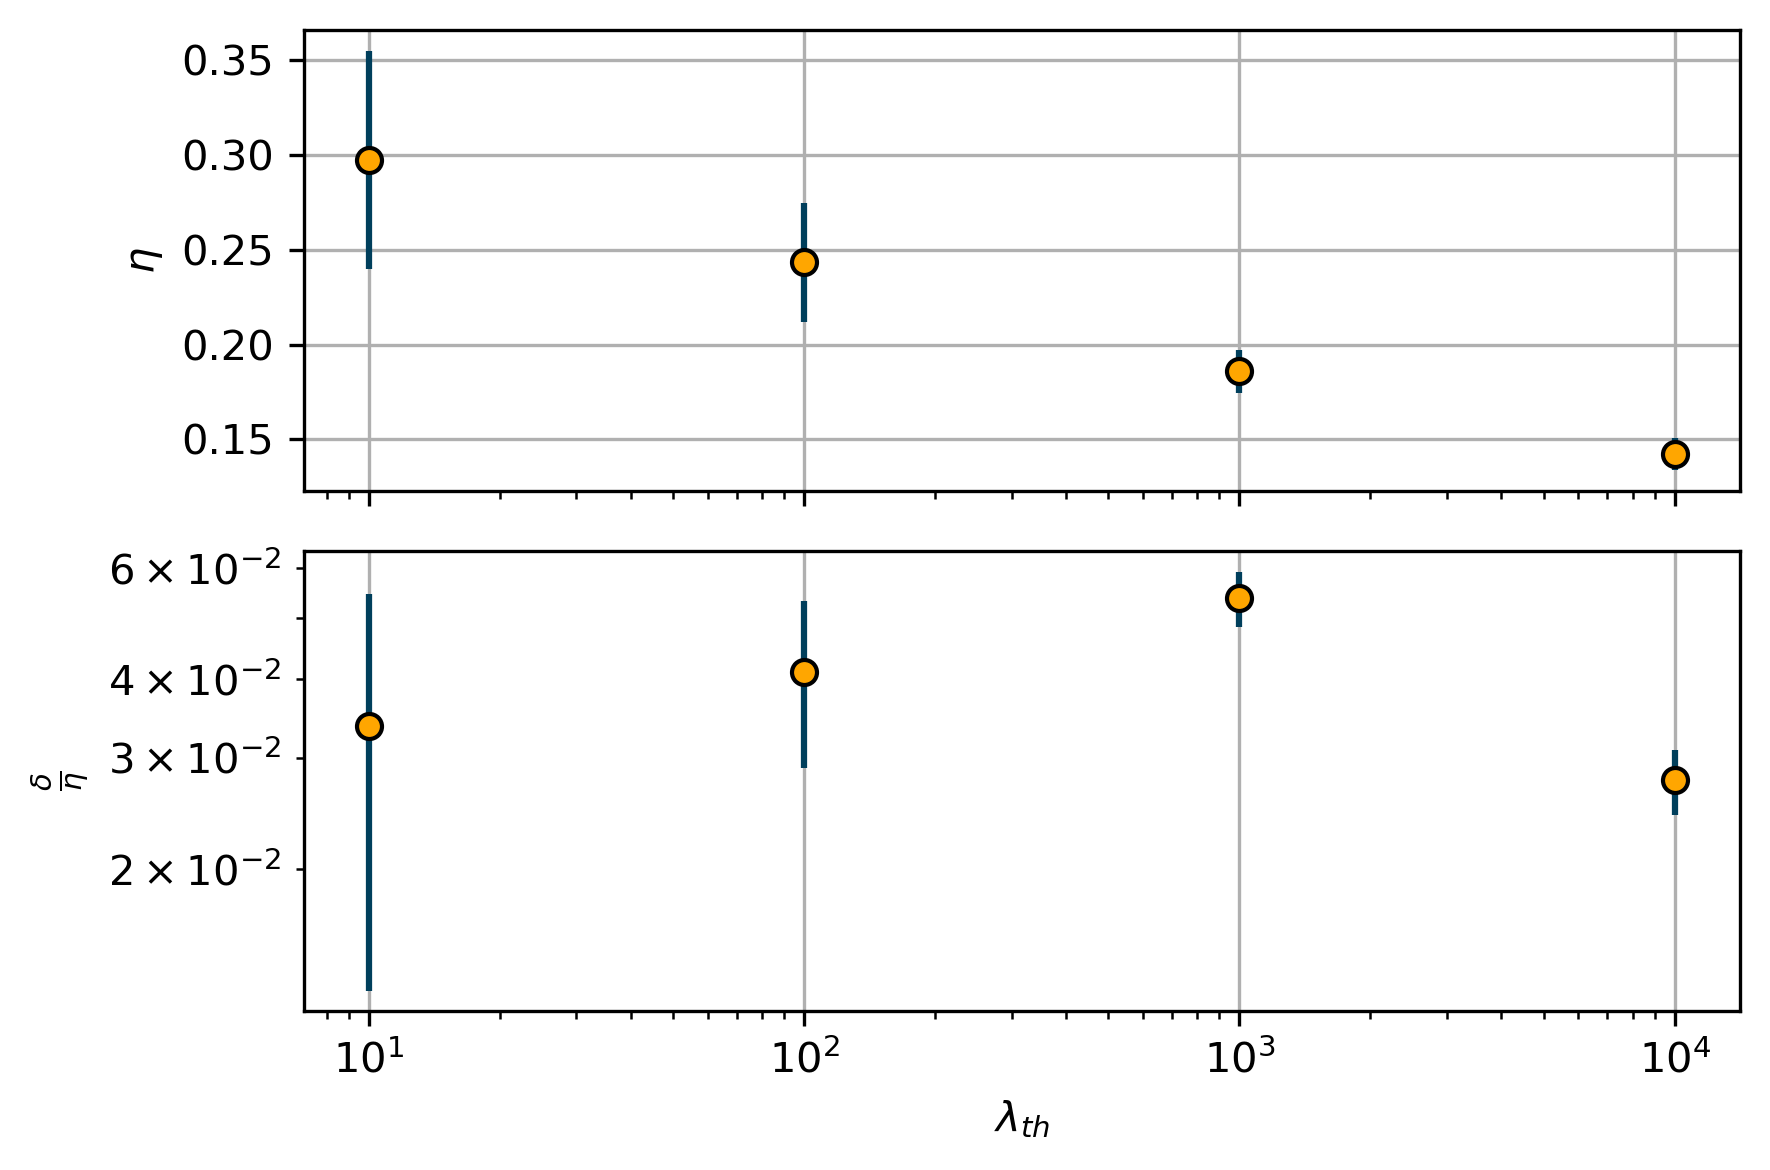

In [264]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)*2) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.07352


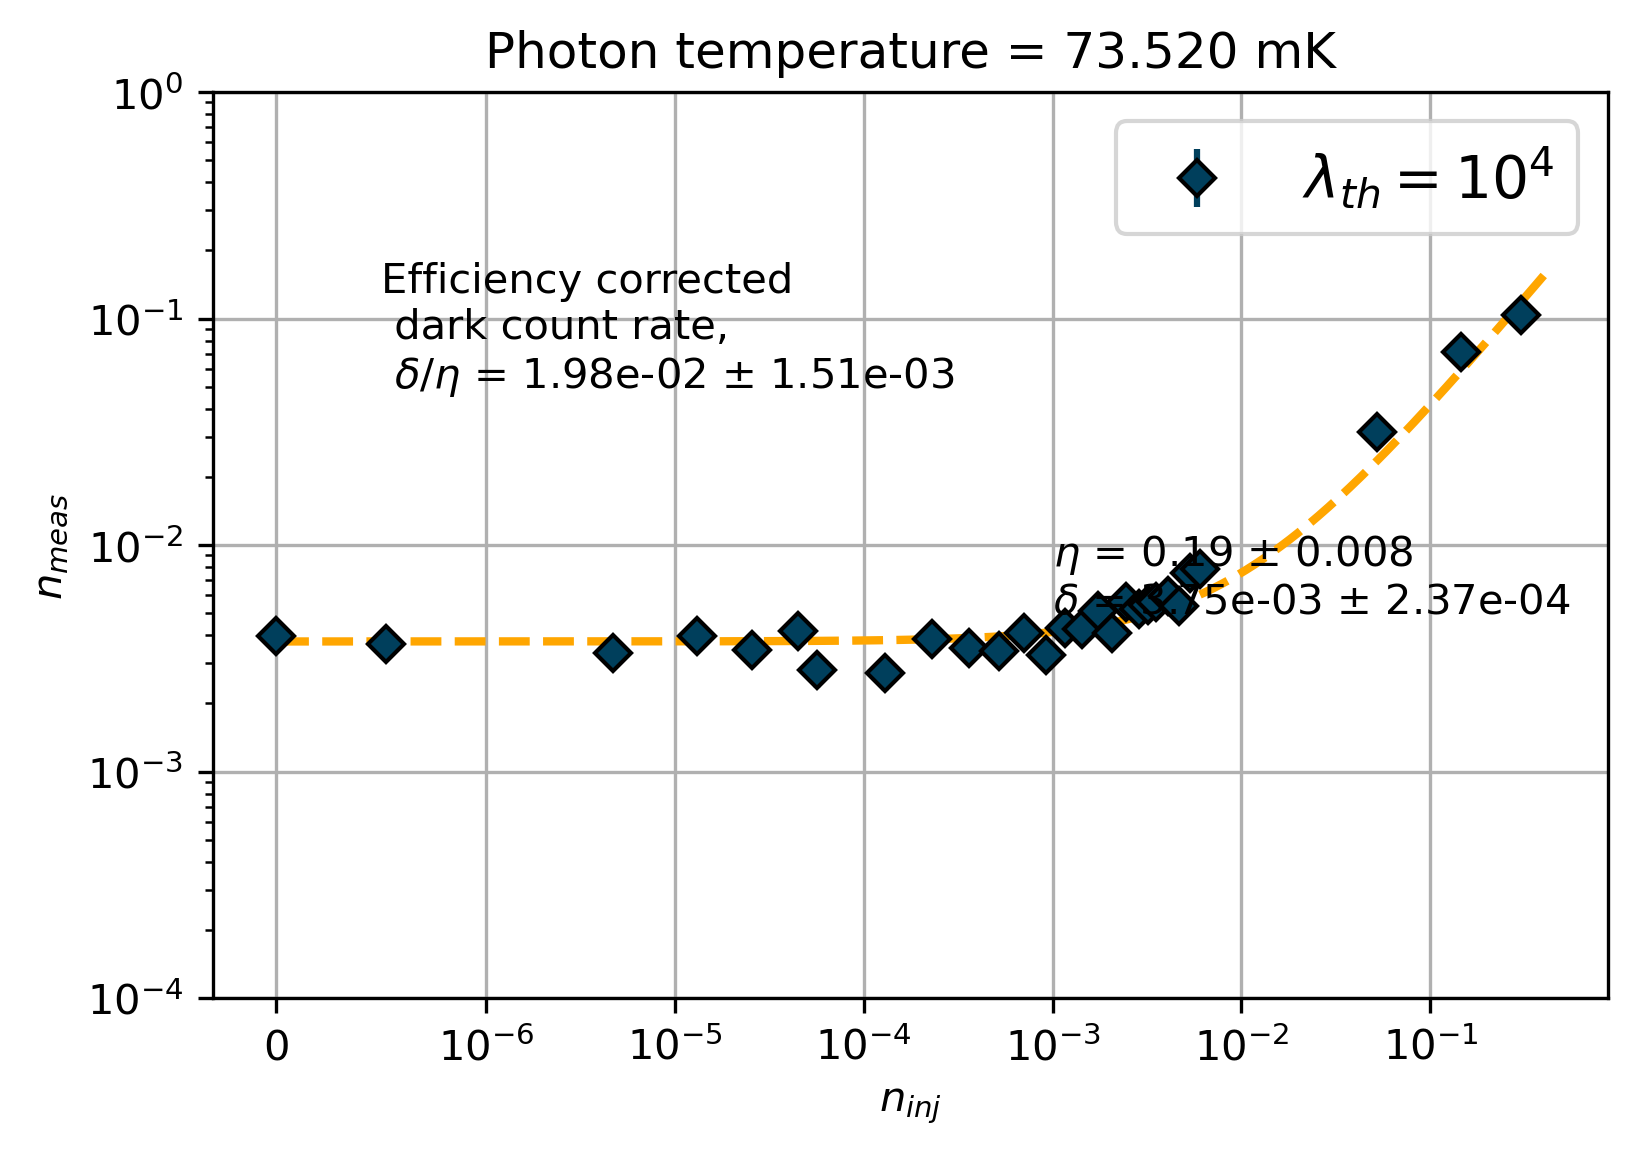

In [265]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
k = 1
plt.figure(dpi=300)
plt.errorbar(n_exp[:-k], y= np.array(y.iloc[-m], dtype=float)[:-k], yerr= np.array(yerr.iloc[-m], dtype=float)[:-k], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp[:-k], ydata=np.array(y.iloc[-m], dtype=float)[:-k], sigma=np.array(yerr.iloc[-m], dtype=float)[:-k], 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-4, 1e0)
plt.text(1e-3, 5e-3, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

In [64]:
5e-2*(1-np.exp(-7/(2*1000))), 

0.00017469410697925627

# Stim Em with repeated pi pulses at |n> = 2

## Camp = 0.0, cav_len = 400 ns

In [158]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.002).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.10, 0.005).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.2).tolist(), 6))
camp.append(0.0)

fock_state = 2

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n2_camp_0.001_len_10.h5']
n2//00000_stim_em_n2_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n2//injected_photon//n2_camp_0.001.h5
(20000, 2)
5170
488
['00000_stim_em_n2_camp_0.003_len_10.h5']
n2//00000_stim_em_n2_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n2//injected_photon//n2_camp_0.003.h5
(20000, 2)
5052
511
['00000_stim_em_n2_camp_0.005_len_10.h5']
n2//00000_stim_em_n2_camp_0.005_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.005, length = 10 ns
[array(0.00361709)]
n2//injected_photon//n2_camp_0.005.h5
(20000, 2)
4965
490
['00000_stim_em_n2_camp_0.007_len_10.h5']
n2//00000_stim_em_n2_camp_0.007_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.007, length = 10 ns
[array(0.00504764)]
n2//injected_photon//n2_camp_0.007.h5
(20000, 2)
4987
513
['00000_stim_em_n2_camp_0.009_len_10.h5']
n2//00000_stim_em_n2_camp_

### Appending

In [261]:
import json
filename = '00003_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.002).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.10, 0.005).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.2).tolist(), 6))
camp.append(0.0)

fock_state = 2

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
#     print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist[1:]):

        filename = data_path+i
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)
    
    with File(filename, 'r') as f:
        pm_temp = list(f['p_m_counts'])
        pn_temp = list(f['p_n_counts'])
        f.close()
    pm_temp.extend(list(p_m_counts))
    pn_temp.extend(list(p_n_counts))

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=np.array(pm_temp))
        f.create_dataset("p_n_counts", data=np.array(pn_temp))
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': pm_temp, 'p_n': pn_temp})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

n2//00001_stim_em_n2_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n2//injected_photon//n2_camp_0.001.h5
(40000, 2)
9803
867
n2//00001_stim_em_n2_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n2//injected_photon//n2_camp_0.003.h5
(40000, 2)
9727
848
n2//00001_stim_em_n2_camp_0.005_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.005, length = 10 ns
[array(0.00361709)]
n2//injected_photon//n2_camp_0.005.h5
(40000, 2)
9727
826
n2//00001_stim_em_n2_camp_0.007_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.007, length = 10 ns
[array(0.00504764)]
n2//injected_photon//n2_camp_0.007.h5
(40000, 2)
9773
874
n2//00001_stim_em_n2_camp_0.009_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.009, length = 10 ns
[array(0.0067126)]
n2//injected_photon//n2_camp_0.009.h5
(40000, 2)
9715
836
n2//00001_stim_em_n2_camp_0.01_len_10.h5
# of 

## Photon counter fit

In [8]:
data_path =  "n2/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 3e2
th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n2_camp_0.0.h5
Total number of events collected: 20000, 4329 events crossed $\lambda_{th, n}$ and 10 events crossed $\lambda_{th, n+1}$
n2_camp_0.001.h5
Total number of events collected: 40000, 8246 events crossed $\lambda_{th, n}$ and 22 events crossed $\lambda_{th, n+1}$
n2_camp_0.003.h5
Total number of events collected: 40000, 8153 events crossed $\lambda_{th, n}$ and 17 events crossed $\lambda_{th, n+1}$
n2_camp_0.005.h5
Total number of events collected: 40000, 8217 events crossed $\lambda_{th, n}$ and 18 events crossed $\lambda_{th, n+1}$
n2_camp_0.007.h5
Total number of events collected: 40000, 8216 events crossed $\lambda_{th, n}$ and 15 events crossed $\lambda_{th, n+1}$
n2_camp_0.009.h5
Total number of events collected: 40000, 8208 events crossed $\lambda_{th, n}$ and 13 events crossed $\lambda_{th, n+1}$
n2_camp_0.01.h5
Total number of events collected: 40000, 8329 events crossed $\lambda_{th, n}$ and 16 events crossed $\lambda_{th, n+1}$
n2_camp_0.015.h5
Total number of even

In [9]:
len(n_exp), np.shape(y)

(29, (4, 24))

In [10]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (29,) (24,) 

ValueError: 'x' and 'y' must have the same size

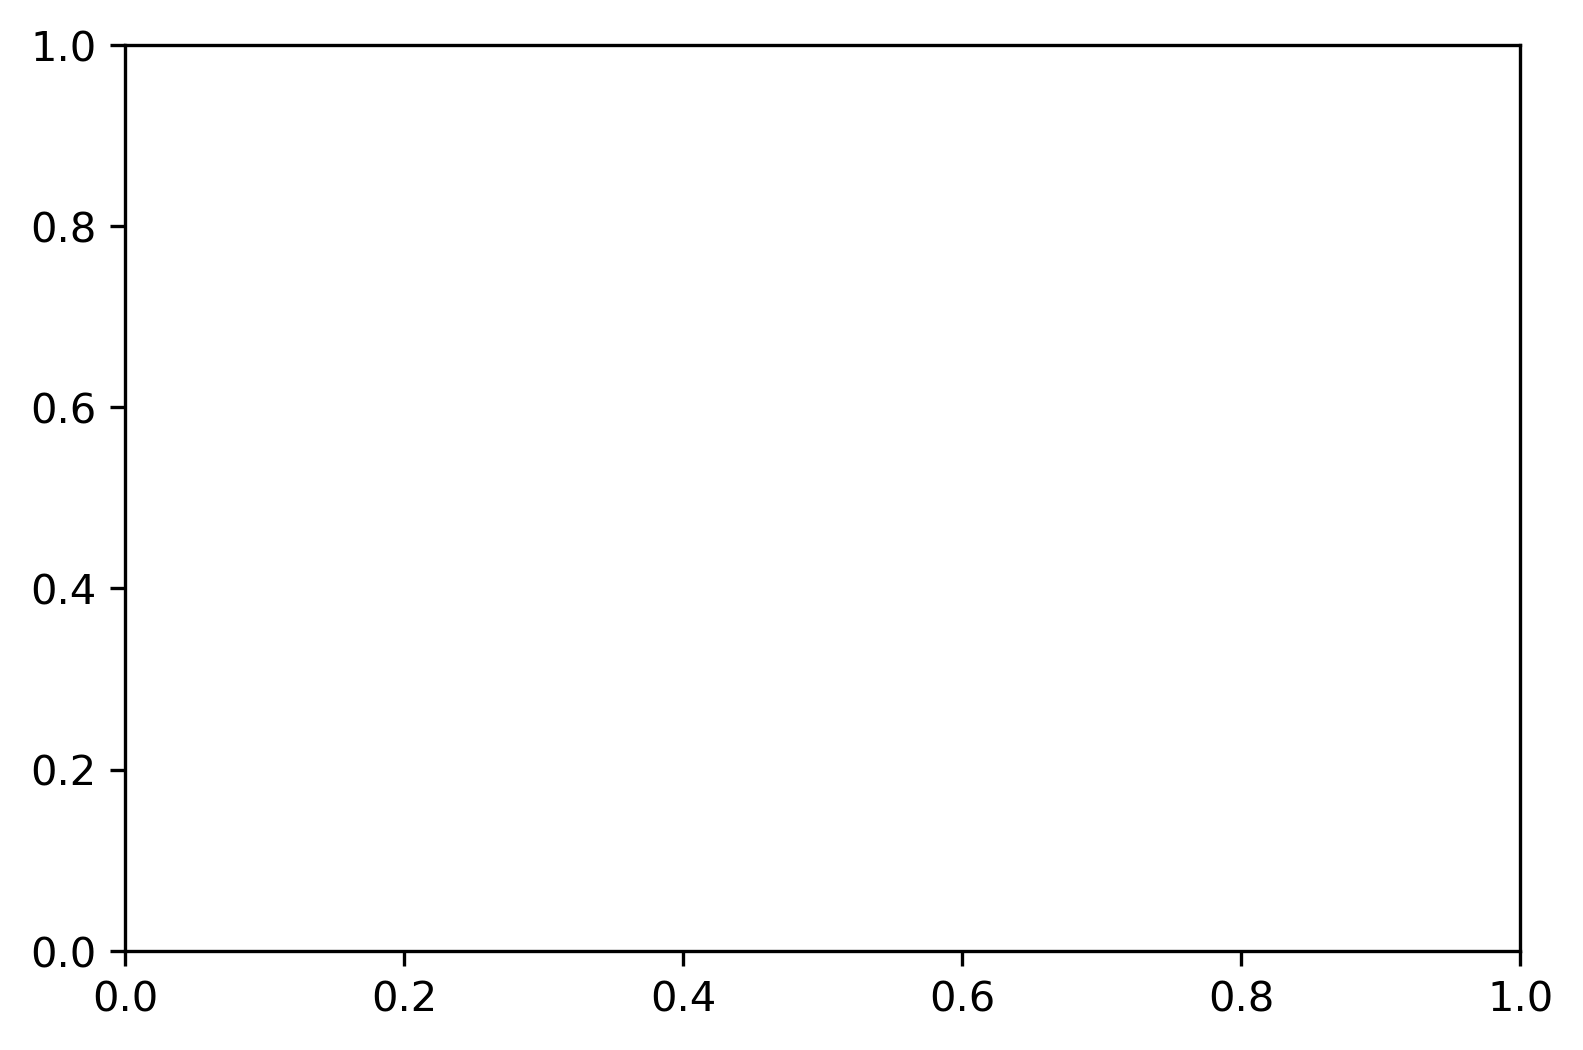

In [274]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
plt.figure(dpi=300)
plt.errorbar(n_exp, y= y.iloc[-m], yerr= yerr.iloc[-m], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[-m], dtype=float), sigma=np.array(yerr.iloc[-m], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-6, 2e0)
plt.text(1e-3, 5e-5, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

# Stim Em with repeated pi pulses at |n> = 3

## Camp = 0.05, cav_len = 400 ns

In [159]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.002).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.10, 0.005).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.2).tolist(), 6))
camp.append(0.0)

fock_state = 3

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n3_camp_0.001_len_10.h5']
n3//00000_stim_em_n3_camp_0.001_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.001, length = 10 ns
[array(0.00072342)]
n3//injected_photon//n3_camp_0.001.h5
(20000, 2)
3108
85
['00000_stim_em_n3_camp_0.003_len_10.h5']
n3//00000_stim_em_n3_camp_0.003_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.003, length = 10 ns
[array(0.00217026)]
n3//injected_photon//n3_camp_0.003.h5
(20000, 2)
3043
89
['00000_stim_em_n3_camp_0.005_len_10.h5']
n3//00000_stim_em_n3_camp_0.005_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.005, length = 10 ns
[array(0.00361709)]
n3//injected_photon//n3_camp_0.005.h5
(20000, 2)
2977
86
['00000_stim_em_n3_camp_0.007_len_10.h5']
n3//00000_stim_em_n3_camp_0.007_len_10.h5
# of π at m= 10, at n = 30
Coherent drive: amp = 0.007, length = 10 ns
[array(0.00504764)]
n3//injected_photon//n3_camp_0.007.h5
(20000, 2)
3095
80
['00000_stim_em_n3_camp_0.009_len_10.h5']
n3//00000_stim_em_n3_camp_0.00

### Appending

In [262]:
import json
filename = '00003_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
# readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.002).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.10, 0.005).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.2).tolist(), 6))
camp.append(0.0)

fock_state = 3

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
#     print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist[1:]):

        filename = data_path+i
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)
    
    with File(filename, 'r') as f:
        pm_temp = list(f['p_m_counts'])
        pn_temp = list(f['p_n_counts'])
        f.close()
    pm_temp.extend(list(p_m_counts))
    pn_temp.extend(list(p_n_counts))

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=np.array(pm_temp))
        f.create_dataset("p_n_counts", data=np.array(pn_temp))
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': pm_temp, 'p_n': pn_temp})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

[]
n3//injected_photon//n3_camp_0.001.h5
(20000, 2)
3108
85
[]
n3//injected_photon//n3_camp_0.003.h5
(20000, 2)
3043
89
[]
n3//injected_photon//n3_camp_0.005.h5
(20000, 2)
2977
86
[]
n3//injected_photon//n3_camp_0.007.h5


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'n3//injected_photon//n3_camp_0.007.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Photon counter fit

In [180]:
data_path =  "n3/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 1e2
th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n3_camp_0.0.h5
Total number of events collected: 20000, 3052 events crossed $\lambda_{th, n}$ and 2 events crossed $\lambda_{th, n+1}$
n3_camp_0.001.h5
Total number of events collected: 20000, 3108 events crossed $\lambda_{th, n}$ and 3 events crossed $\lambda_{th, n+1}$
n3_camp_0.003.h5
Total number of events collected: 20000, 3043 events crossed $\lambda_{th, n}$ and 5 events crossed $\lambda_{th, n+1}$
n3_camp_0.005.h5
Total number of events collected: 20000, 2977 events crossed $\lambda_{th, n}$ and 7 events crossed $\lambda_{th, n+1}$
n3_camp_0.009.h5
Total number of events collected: 20000, 3037 events crossed $\lambda_{th, n}$ and 5 events crossed $\lambda_{th, n+1}$
n3_camp_0.01.h5
Total number of events collected: 20000, 3079 events crossed $\lambda_{th, n}$ and 5 events crossed $\lambda_{th, n+1}$
n3_camp_0.015.h5
Total number of events collected: 20000, 3004 events crossed $\lambda_{th, n}$ and 6 events crossed $\lambda_{th, n+1}$
n3_camp_0.02.h5
Total number of events colle

In [53]:
3/2574

0.0011655011655011655

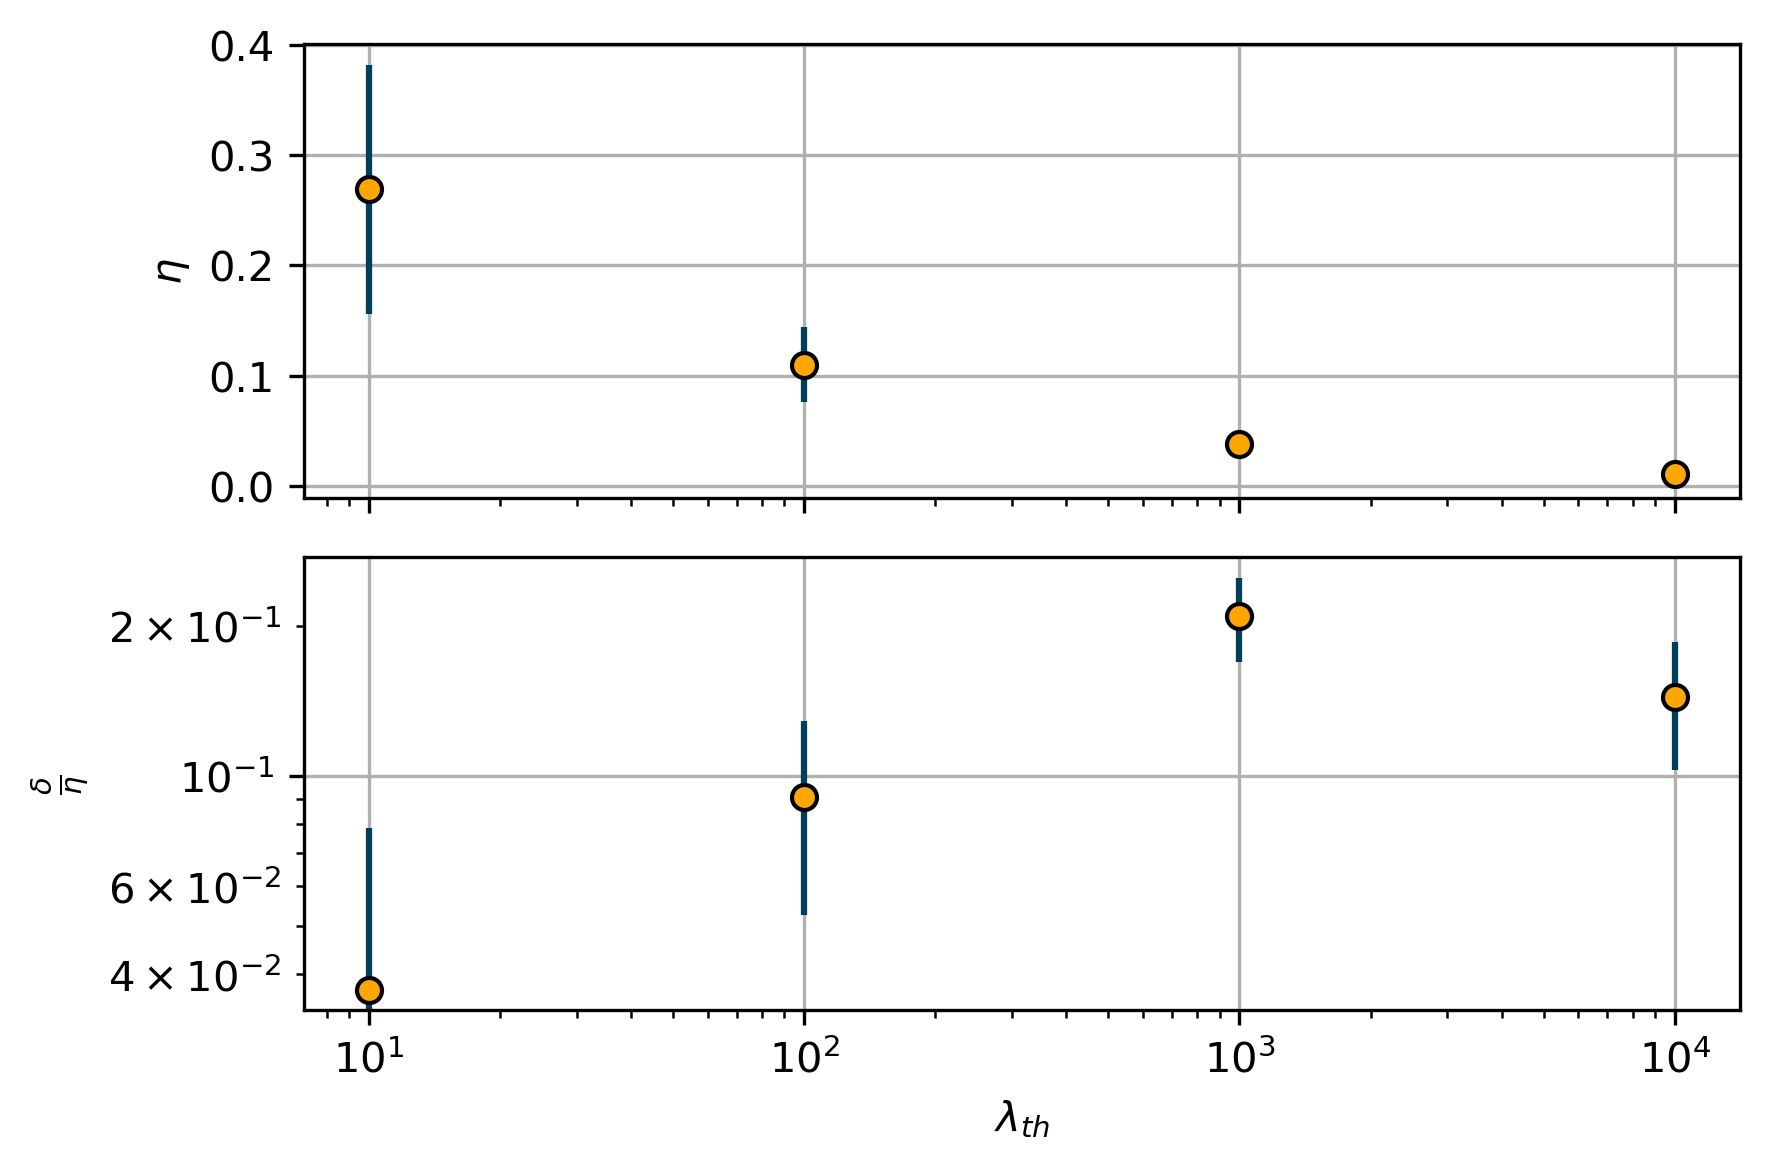

In [181]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.10024


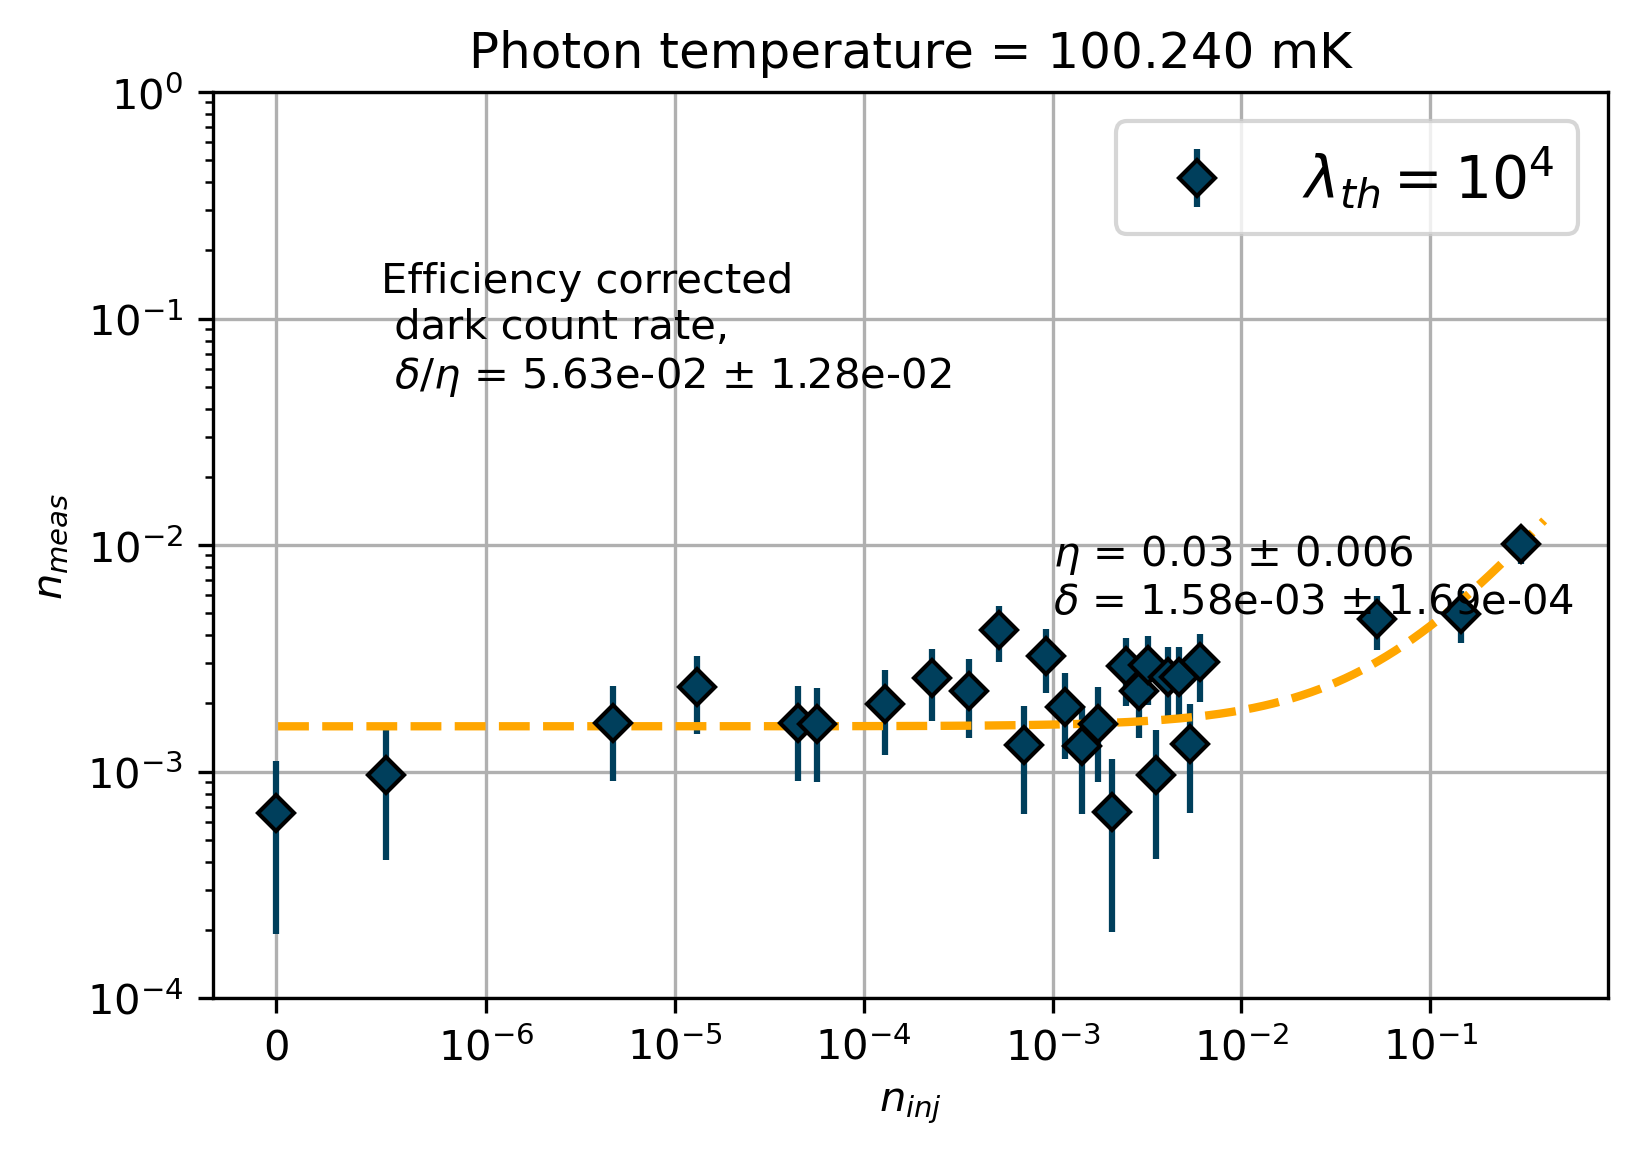

In [182]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
k = 1
plt.figure(dpi=300)
plt.errorbar(n_exp[:-k], y= np.array(y.iloc[-m], dtype=float)[:-k], yerr= np.array(yerr.iloc[-m], dtype=float)[:-k], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp[:-k], ydata=np.array(y.iloc[-m], dtype=float)[:-k], sigma=np.array(yerr.iloc[-m], dtype=float)[:-k], 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-4, 1e0)
plt.text(1e-3, 5e-3, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

In [48]:
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = hbar*w/(k*np.log(1/3.28e-4))
print(T)

0.03595919112878462


# Stim Em with repeated pi pulses at |n> = 6

In [39]:
import json
filename = '00001_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']
readout_params['nth'] = 0.0

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 6

data_path = 'n' + str(fock_state)+'//'
inj_path = 'n' + str(fock_state)+'//injected_photon//'

for amp in camp[:]:
    data_path = 'n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_m, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=None, fstate_in=fock_state)
        p_m_counts.extend(p_m)
        p_n_counts.extend(p_n)
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_m_counts", data=p_m_counts)
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_m = df['p_m'][df['p_m']>th1].count()
    print(count_m)
    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n6_camp_0.001_len_10.h5']
n6//00000_stim_em_n6_camp_0.001_len_10.h5


KeyboardInterrupt: 

In [40]:
data_path =  "n6/injected_photon/"
filenames_like = os.listdir(data_path)

th_m = 1e2
th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_counts = np.array(a['p_m_counts'], dtype=float)
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = array(a['alpha'])
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_m_counts, p_n_counts)):
            if p[0] > th_m:
                count_m+=1
            if p[0] > th_m and p[1] > th:
                count_n+=1
        t = count_n/count_m
        eta_initial = count_m/len(p_m_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/count_m)
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_m_counts), count_m, count_n))
    detected_th[np.round(alpha, 6)] = detect
    detected_th_err[np.round(alpha, 6)] = detect_err
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n6_camp_0.001.h5
Total number of events collected: 20000, 4053 events crossed $\lambda_{th, n}$ and 6 events crossed $\lambda_{th, n+1}$
n6_camp_0.002.h5
Total number of events collected: 20000, 3981 events crossed $\lambda_{th, n}$ and 6 events crossed $\lambda_{th, n+1}$
n6_camp_0.003.h5
Total number of events collected: 20000, 4064 events crossed $\lambda_{th, n}$ and 6 events crossed $\lambda_{th, n+1}$
n6_camp_0.004.h5
Total number of events collected: 20000, 4150 events crossed $\lambda_{th, n}$ and 6 events crossed $\lambda_{th, n+1}$
n6_camp_0.005.h5
Total number of events collected: 20000, 3858 events crossed $\lambda_{th, n}$ and 7 events crossed $\lambda_{th, n+1}$
n6_camp_0.006.h5
Total number of events collected: 20000, 4005 events crossed $\lambda_{th, n}$ and 7 events crossed $\lambda_{th, n+1}$


0.04462


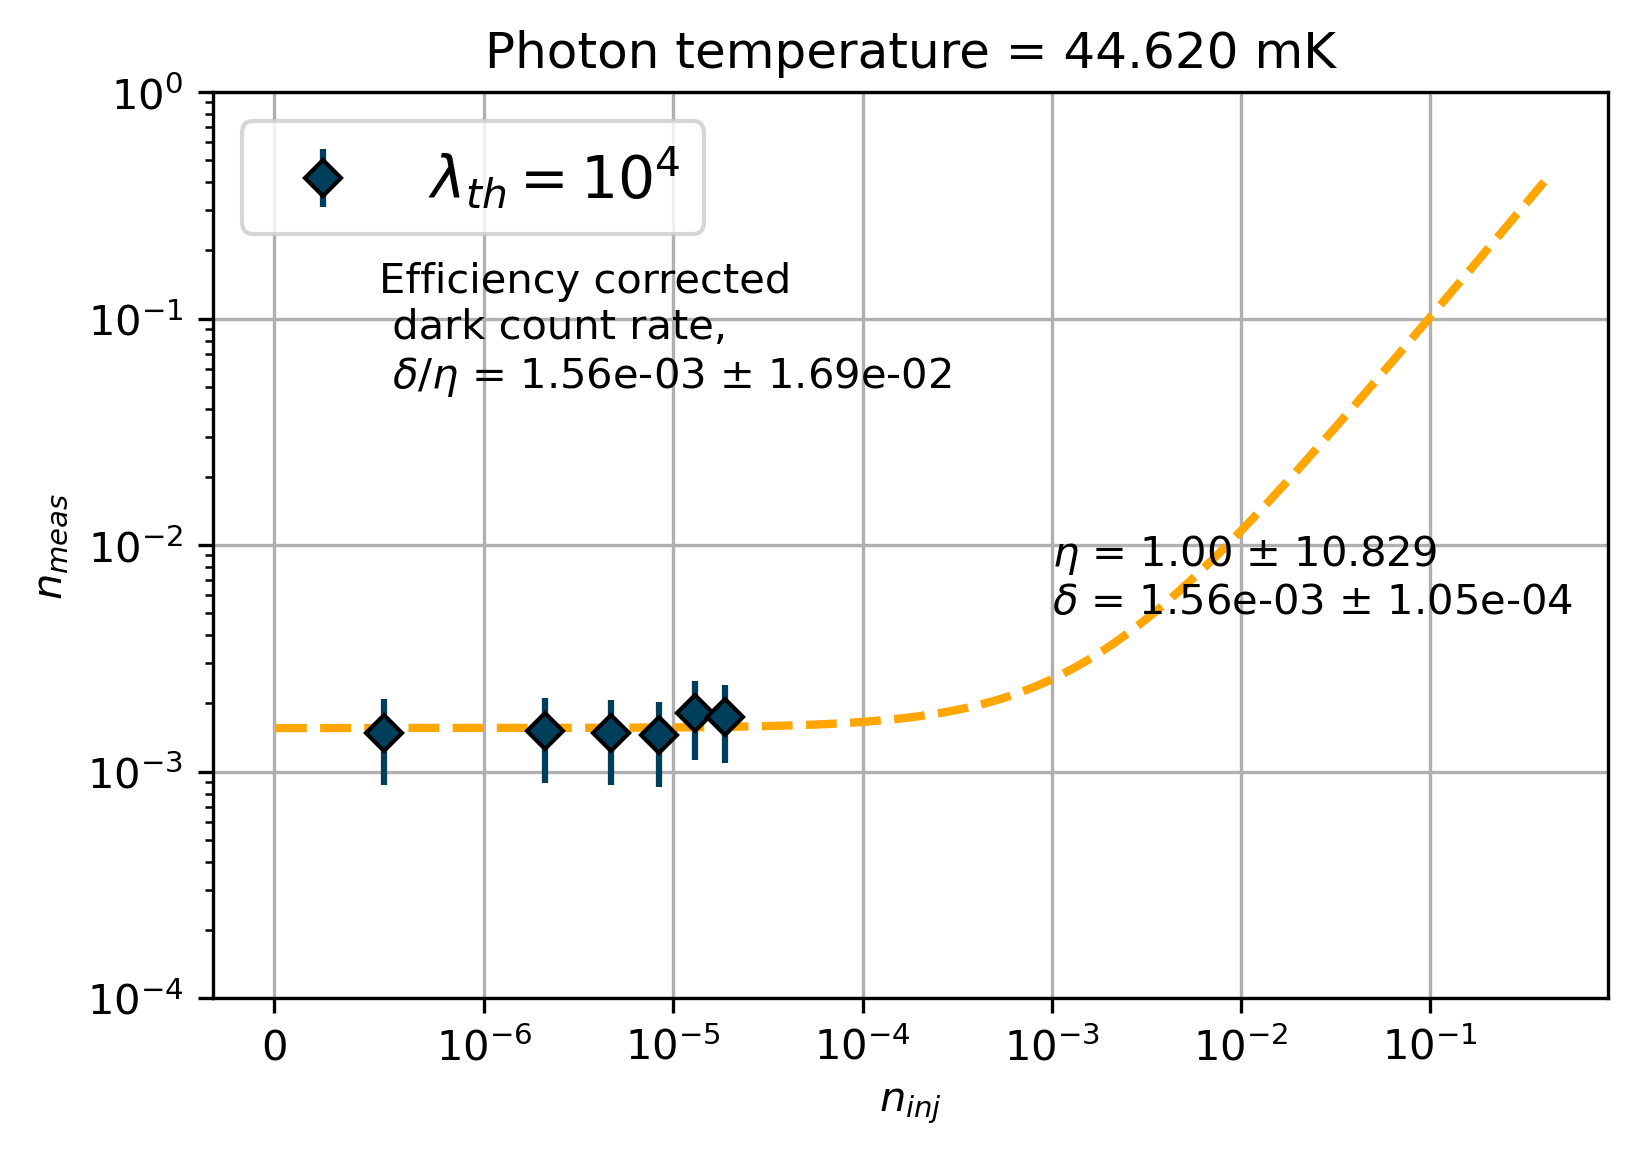

In [41]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
plt.figure(dpi=300)
plt.errorbar(n_exp[:], y= np.array(y.iloc[-m], dtype=float)[:], yerr= np.array(yerr.iloc[-m], dtype=float)[:], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp[:], ydata=np.array(y.iloc[-m], dtype=float)[:], sigma=np.array(yerr.iloc[-m], dtype=float)[:], 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-4, 1e0)
plt.text(1e-3, 5e-3, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

In [51]:
6/4053

0.0014803849000740192